# Telecom Churn Case Study

                                                                                            - Rajagopal Shenoy G
                                                                                            - Anindya Sudhir

## Problem Statement

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

High-value Churn should be predicted:<br>In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

Build models to predict churn. The predictive model will serve two purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

### Approach

Following steps are taken to build the model:

1. Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

2. Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

3. Derive new features.

4. Reduce the number of variables using PCA.

5. Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

6. Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

7. Finally, choose a model based on some evaluation metric.

8. The above model will only be able to achieve one of the two goals - to predict customers who will churn. You can’t use the above model to identify the important features for churn. That’s because PCA usually creates components which are not easy to interpret.

9. Therefore, build another model with the main objective of identifying important predictor attributes which help the business understand indicators of churn. A good choice to identify important variables is a logistic regression model or a model from the tree family. In case of logistic regression, make sure to handle multi-collinearity.

10. After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

11. Finally, recommend strategies to manage customer churn based on your observations.

In [1]:
# Import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from sklearn.tree import export_graphviz 
from io import StringIO
import pydotplus
from IPython.display import Image  

# Many columns will be created, it is good to see all of them
pd.set_option('display.max_columns', 300)
pd.set_option("display.max_rows", 300)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Preparation

Read the telecom data

In [2]:
# Read the telecom churn data into a dataframe
phone_orig = pd.read_csv("telecom_churn_data.csv")
phone_orig.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [3]:
print('Data shape:', phone_orig.shape)

Data shape: (99999, 226)


### Selecting High Value Customers

- As the dataset is huge and as we are only interested in high value customers, first step would be filter for only the required the data 
- This will reduce the amount of data and then we can proceed with data inspection, cleaning and imputation

- High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)
- Columns `total_rech_data_6`, `total_rech_data_7`, `av_rech_amt_data_6`, `av_rech_amt_data_7`, `total_rech_amt_6` and `total_rech_amt_7` indicate the recharges happened during the good phase

In [4]:
# First check if the columns total_rech_data_6, total_rech_data_6, av_rech_amt_data_6, av_rech_amt_data_7, 
# total_rech_amt_6 and total_rech_amt_7 have any missing/wrong data

print(phone_orig['total_rech_data_6'].isnull().sum())
print(phone_orig['total_rech_data_6'].isnull().sum())
print(phone_orig['av_rech_amt_data_6'].isnull().sum())
print(phone_orig['av_rech_amt_data_7'].isnull().sum())
print(phone_orig['total_rech_amt_6'].isnull().sum())
print(phone_orig['total_rech_amt_7'].isnull().sum())

74846
74846
74846
74428
0
0


In [5]:
# As there are missing values, they shall be treated as 0 while calculating the average recharge 

# Calculate the total data recharge amount for June and July = number of recharges * average recharge amount
phone_orig['total_rech_amt_data_6'] = phone_orig['av_rech_amt_data_6'].fillna(0) * phone_orig['total_rech_data_6'].fillna(0)
phone_orig['total_rech_amt_data_7'] = phone_orig['av_rech_amt_data_7'].fillna(0) * phone_orig['total_rech_data_7'].fillna(0)

# Calculate total recharge amount for June and July = total call recharge amount + total data recharge amount
phone_orig['total_amt_6'] = phone_orig['total_rech_amt_6'] + phone_orig['total_rech_amt_data_6']
phone_orig['total_amt_7'] = phone_orig['total_rech_amt_7'] + phone_orig['total_rech_amt_data_7']

# Calculate the average recharge done in June and July
phone_orig['avg_rech_amt_6_7'] = (phone_orig['total_amt_6'] + phone_orig['total_amt_7']) / 2

# Calculate the 70th Percentile
phone_70 = phone_orig['avg_rech_amt_6_7'].quantile(0.7)
print('70th Percentile of average reacharge amount in good phase:', phone_70)

70th Percentile of average reacharge amount in good phase: 478.0


In [6]:
# Filter for high value customers i.e. customers with average recharge amount greater than 70th percentile
phone = phone_orig.loc[phone_orig['avg_rech_amt_6_7'] > phone_70]
phone.shape

(29953, 231)

In [7]:
# Once we have the high value customers, delete the columns created to filter high value customers
phone.drop(['total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_amt_6', 'total_amt_7', 'avg_rech_amt_6_7'], 
           axis = 1, inplace = True)
phone.shape

(29953, 226)

Now we are left with 29953 rows from the original 99999

### Identifying the Churned Customers

Tag the churned customers (churn = 1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: `total_ic_mou_9`, `total_og_mou_9`, `vol_2g_mb_9` and `vol_3g_mb_9`

In [8]:
# Customers who have churned will have no call or data history in the fourth month i.e. the sum will be 0
# Churn = 1 for the churned customers
# Churn = 0 for the non-churned customers
phone['churn'] = np.where(phone[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis = 1) == 0, 1, 0)
phone.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0             9/30/2014   197.385   214.816   213.803   21.100          NaN   
7             9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8             9/30/2014   378.721   492.223   137.362  166.787       413.69   
21            9/30/2014   514.453   597.753   637.760  578.596       102.41   
23            9/30/2014    74.350   193.897   366.966  811.480        48.96   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0           NaN         0.00          NaN           NaN           NaN   
7         54.68        52.29          NaN        453.43        567.16   
8        351.03        35.08        33.46         94.66         80.63   
21       132.11        85.14       161.63        757.93        896.68   
23        50.66        33.58        15.74         85.41         89.36   

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0           0.00           NaN            NaN            NaN           0.00   
7         325.91           NaN          16.23          33.49          31.64   
8         136.48        108.71           0.00           0.00           0.00   
21        983.39        869.89           0.00           0.00           0.00   
23        205.89        111.88           0.00           0.00           0.00   

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0             NaN            NaN            NaN           0.00            NaN   
7             NaN          23.74          12.59          38.06            NaN   
8             0.0           0.00           0.00           0.00            0.0   
21            0.0           0.00           0.00           0.00            0.0   
23            0.0           0.00           0.00           0.00            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0                NaN               NaN              0.00               NaN   
7              51.39             31.38             40.28               NaN   
8             297.13            217.59             12.49             26.13   
21              4.48              6.16             23.34             29.98   
23             48.96             50.66             33.58             15.74   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0                NaN               NaN              0.00               NaN   
7             308.63            447.38            162.28               NaN   
8              80.96             70.58             50.54             34.58   
21             91.81             87.93            104.81            107.54   
23             82.94             83.01            148.56             83.73   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0                NaN               NaN              0.00               NaN   
7              62.13             55.14             53.23               NaN   
8               0.00              0.00              0.00    

In [9]:
# Check the data imbalance i.e the churn vs non-churn ratio
phone['churn'].value_counts(1) * 100

0    91.877274
1     8.122726
Name: churn, dtype: float64

- As one can see, there are about 92% entries with no churn and only 8% with churn. 
- This is highly imbalanced data, which will be corrected using class weights during hyperparameter tuning later in the module

### Remove attributes of the Churn Phase

- Prediction on whether a customer will churn or not has to be done in the Action Phase i.e. 3rd month.
- This means data related to the Churn Phase i.e. 4th month are no longer required
- Hence they will be dropped

In [10]:
# Data related to the Churn Phase are present in columns with suffix _9 -> Delete those rows
drop_cols = phone.columns[phone.columns.str.contains('_9')]

phone.drop(drop_cols, axis = 1, inplace = True)
phone.shape

(29953, 173)

In [11]:
phone.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
0             6/30/2014            7/31/2014            8/31/2014   197.385   
7             6/30/2014            7/31/2014            8/31/2014  1069.180   
8             6/30/2014            7/31/2014            8/31/2014   378.721   
21            6/30/2014            7/31/2014            8/31/2014   514.453   
23            6/30/2014            7/31/2014            8/31/2014    74.350   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0    214.816   213.803          NaN          NaN         0.00           NaN   
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
21   597.753   637.760       102.41       132.11        85.14        757.93   
23   193.897   366.966        48.96        50.66        33.58         85.41   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0            NaN          0.00            NaN            NaN           0.00   
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
21        896.68        983.39           0.00           0.00           0.00   
23         89.36        205.89           0.00           0.00           0.00   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0             NaN            NaN           0.00               NaN   
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
21           0.00           0.00           0.00              4.48   
23           0.00           0.00           0.00             48.96   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0                NaN              0.00               NaN               NaN   
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
21              6.16             23.34             91.81             87.93   
23             50.66             33.58             82.94             83.01   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0               0.00               NaN               NaN              0.00   
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
21            104.81              0.75              0.00              1.58   
23            148.56              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0                NaN               NaN              0.00           NaN   
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
21               0.0               0.0              0.00         97.04   
23               0.0               0.0             17.71        131.91   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0            NaN          0.00               NaN               NaN   
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
21         94.09    

### Data Cleaning and Deriving New Features

In [12]:
# Get the datatypes, counts, number of nulls, percentage of nulls and number of unique values of each column

# Data Frame to hold the statistics
details_phone = pd.DataFrame()

# Get the datatype of each column
details_phone['Data Type'] = phone.dtypes
# Get the counts in each column
details_phone['Count'] = phone.apply(lambda x: x.count())
# Get the count of nulls in each column
details_phone['Nulls'] = phone.apply(lambda x: x.isnull().sum())
# Get the null percentage in each column
details_phone['Null Percent'] = round((phone.isnull().sum()/ phone.shape[0]) * 100)
# Get the number of unique entries in each column
details_phone['Uniques'] = phone.apply(lambda x: x.unique().shape[0])

details_phone.transpose()

mobile_number circle_id loc_og_t2o_mou std_og_t2o_mou  \
Data Type            int64     int64        float64        float64   
Count                29953     29953          29730          29730   
Nulls                    0         0            223            223   
Null Percent             0         0              1              1   
Uniques              29953         1              2              2   

             loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
Data Type           float64               object               object   
Count                 29730                29953                29926   
Nulls                   223                    0                   27   
Null Percent              1                    0                    0   
Uniques                   2                    1                    2   

             last_date_of_month_8   arpu_6   arpu_7   arpu_8 onnet_mou_6  \
Data Type                  object  float64  float64  float64     float64   
Count                       29788    29953    29953    29953       29411   
Nulls                         165        0        0        0         542   
Null Percent                    1        0        0        0           2   
Uniques                         2    29029    29040    28035       16873   

             onnet_mou_7 onnet_mou_8 offnet_mou_6 offnet_mou_7 offnet_mou_8  \
Data Type        float64     float64      float64      float64      float64   
Count              29417       28781        29411        29417        28781   
Nulls                536        1172          542          536         1172   
Null Percent           2           4            2            2            4   
Uniques            16974       15855        21199        21234        20141   

             roam_ic_mou_6 roam_ic_mou_7 roam_ic_mou_8 roam_og_mou_6  \
Data Type          float64       float64       float64       float64   
Count                29411         29417         28781         29411   
Nulls                  542           536          1172           542   
Null Percent             2             2             4             2   
Uniques               4046          3382          3432          4743   

             roam_og_mou_7 roam_og_mou_8 loc_og_t2t_mou_6 loc_og_t2t_mou_7  \
Data Type          float64       float64          float64          float64   
Count                29417         28781            29411            29417   
Nulls                  536          1172              542              536   
Null Percent             2             4                2                2   
Uniques               3989          3997            10417            10389   

             loc_og_t2t_mou_8 loc_og_t2m_mou_6 loc_og_t2m_mou_7  \
Data Type             float64          float64          float64   
Count                   28781            29411            29417   
Nulls                    1172              542              536   
Null Percent                4                2                2   
Uniques                 10057            15608            15660   

             loc_og_t2m_mou_8 loc_og_t2f_mou_6 loc_og_t2f_mou_7  \
Data Type             float64          float64          float64   
Count                   28781            29411            29417   
Nulls                    1172              542              536   
Null Percent                4                2                2   
Uniques                 15119             3090             3098   

             loc_og_t2f_mou_8 loc_og_t2c_mou_6 loc_og_t2c_mou_7  \
Data Type             float64          float64          float64   
Count                   28781            29411            29417   
Nulls                    1172              542              536   
Null Percent                4                2                2   
Uniques                  2989             1683             1764   

             loc_og_t2c_mou_8 loc_og_mou_6 loc_og_mou_7 loc_og_mou_8  \
Data Type             float64      flo

- As seen in table above, there are many columns with only one value through out
- Such columns will be dropped from the analysis

- As seen in table above, there are many columns have more than 40% missing values
- Such columns will be dropped from the analysis

In [13]:
# Select and drop columns with only one value through out
# i.e. either Uniques == 1 or when Uniques == 2 but with Nulls != 0
drop_cols = list(details_phone[details_phone['Uniques'] <= 2].index)
drop_cols.remove('churn')
print('Following columns are dropped: ', drop_cols)

# Drop these columns from the data frame
phone.drop(drop_cols, axis = 1, inplace = True)
phone.shape

Following columns are dropped:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


(29953, 160)

- Create derived columns for the three months based on average recharge amount and the total recharge data
- Create derived columns for the three months combining the 2G and 3G ARPU

In [14]:
# Deriving new features for keeping track of total data recharge amount spent by customer

# Calculate the total data recharge amount for every month = number of recharges * average recharge amount
phone['total_rech_amt_data_6'] = phone['av_rech_amt_data_6'].fillna(0) * phone['total_rech_data_6'].fillna(0)
phone['total_rech_amt_data_7'] = phone['av_rech_amt_data_7'].fillna(0) * phone['total_rech_data_7'].fillna(0)
phone['total_rech_amt_data_8'] = phone['av_rech_amt_data_8'].fillna(0) * phone['total_rech_data_8'].fillna(0)

# Calculate the total ARPU for every month by combining 2G and 3G ARPUs
phone['total_arpu_data_6'] = phone['arpu_2g_6'].fillna(0) + phone['arpu_3g_6'].fillna(0)
phone['total_arpu_data_7'] = phone['arpu_2g_7'].fillna(0) + phone['arpu_3g_7'].fillna(0)
phone['total_arpu_data_8'] = phone['arpu_2g_8'].fillna(0) + phone['arpu_3g_8'].fillna(0)

In [15]:
# Drop the columns with missing values >= 40%
drop_cols = list(details_phone[details_phone['Null Percent'] >= 40].index)
print('Following columns are dropped: ', drop_cols)

# Drop these columns from the data frame
phone.drop(drop_cols, axis = 1, inplace = True)
phone.shape

Following columns are dropped:  ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


(29953, 136)

In [16]:
# Get the datatypes, counts, number of nulls, percentage of nulls and number of unique values of each column

# Data Frame to hold the statistics
details_phone = pd.DataFrame()

# Get the datatype of each column
details_phone['Data Type'] = phone.dtypes
# Get the counts in each column
details_phone['Count'] = phone.apply(lambda x: x.count())
# Get the count of nulls in each column
details_phone['Nulls'] = phone.apply(lambda x: x.isnull().sum())
# Get the null percentage in each column
details_phone['Null Percent'] = round((phone.isnull().sum()/ phone.shape[0]) * 100, 1)
# Get the number of unique entries in each column
details_phone['Uniques'] = phone.apply(lambda x: x.unique().shape[0])

details_phone.transpose()

mobile_number   arpu_6   arpu_7   arpu_8 onnet_mou_6 onnet_mou_7  \
Data Type            int64  float64  float64  float64     float64     float64   
Count                29953    29953    29953    29953       29411       29417   
Nulls                    0        0        0        0         542         536   
Null Percent             0        0        0        0         1.8         1.8   
Uniques              29953    29029    29040    28035       16873       16974   

             onnet_mou_8 offnet_mou_6 offnet_mou_7 offnet_mou_8 roam_ic_mou_6  \
Data Type        float64      float64      float64      float64       float64   
Count              28781        29411        29417        28781         29411   
Nulls               1172          542          536         1172           542   
Null Percent         3.9          1.8          1.8          3.9           1.8   
Uniques            15855        21199        21234        20141          4046   

             roam_ic_mou_7 roam_ic_mou_8 roam_og_mou_6 roam_og_mou_7  \
Data Type          float64       float64       float64       float64   
Count                29417         28781         29411         29417   
Nulls                  536          1172           542           536   
Null Percent           1.8           3.9           1.8           1.8   
Uniques               3382          3432          4743          3989   

             roam_og_mou_8 loc_og_t2t_mou_6 loc_og_t2t_mou_7 loc_og_t2t_mou_8  \
Data Type          float64          float64          float64          float64   
Count                28781            29411            29417            28781   
Nulls                 1172              542              536             1172   
Null Percent           3.9              1.8              1.8              3.9   
Uniques               3997            10417            10389            10057   

             loc_og_t2m_mou_6 loc_og_t2m_mou_7 loc_og_t2m_mou_8  \
Data Type             float64          float64          float64   
Count                   29411            29417            28781   
Nulls                     542              536             1172   
Null Percent              1.8              1.8              3.9   
Uniques                 15608            15660            15119   

             loc_og_t2f_mou_6 loc_og_t2f_mou_7 loc_og_t2f_mou_8  \
Data Type             float64          float64          float64   
Count                   29411            29417            28781   
Nulls                     542              536             1172   
Null Percent              1.8              1.8              3.9   
Uniques                  3090             3098             2989   

             loc_og_t2c_mou_6 loc_og_t2c_mou_7 loc_og_t2c_mou_8 loc_og_mou_6  \
Data Type             float64          float64          float64      float64   
Count                   29411            29417            28781        29411   
Nulls                     542              536             1172          542   
Null Percent              1.8              1.8              3.9          1.8   
Uniques                  1683             1764             1721        18335   

             loc_og_mou_7 loc_og_mou_8 std_og_t2t_mou_6 std_og_t2t_mou_7  \
Data Type         float64      float64          float64          float64   
Count               29417        28781            29411            29417   
Nulls                 536         1172              542              536   
Null Percent          1.8          3.9              1.8              1.8   
Uniques             18494        17566            11086            11239   

             std_og_t2t_mou_8 std_og_t2m_mou_6 std_og_t2m_mou_7  \
Data Type             float64          float64          float64   
Count                   28781            29411            29417   
Nulls                    1172              542              536   
Null Percent              3.9              1.8              1.8   
Uniques                 10244           

- As seen in the table above, there are columns with 0.1 - 4% missing values
- That means 0.1 - 4% rows have null values in some columns
- This is a small number given that we have good amount of data available (i.e. 29953 rows)
- Hence these rows can be dropped from the dataframe

In [17]:
# Get columns with null values
cols_nulls = list(details_phone[details_phone['Nulls'] > 0].index)

# Drop those rows which have null values in above columns
for col in cols_nulls:
    phone = phone[phone[col].notnull()]
    
phone.shape

(28119, 136)

Four columns are named with the month name instead of _6, _7, _8 and _9 (i.e. jun_vbc_3g, jul_vbc_3g, aug_vbc_3g and sep_vbc_3g. These shall be corrected

In [18]:
# Correct column names which have used month name instead of _6, _7 or _8
phone.rename(columns = {'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8'}, inplace = True)

# Drop the Churn phase column i.e. September month column i.e. sep_vbc_3g
phone.drop(['sep_vbc_3g'], axis = 1, inplace = True)

phone.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7      7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8      7001524846   378.721   492.223   137.362       413.69       351.03   
21     7002124215   514.453   597.753   637.760       102.41       132.11   
23     7000887461    74.350   193.897   366.966        48.96        50.66   
33     7000149764   977.020  2362.833   409.230         0.00         0.00   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
7         52.29        453.43        567.16        325.91          16.23   
8         35.08         94.66         80.63        136.48           0.00   
21        85.14        757.93        896.68        983.39           0.00   
23        33.58         85.41         89.36        205.89           0.00   
33         0.00          0.00          0.00          0.00           0.00   

    roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           33.49          31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00           0.00   
33           0.00           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   
33              0.00              0.00              0.00              0.00   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   
33              0.00              0.00              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   
33              0.00               0.0               0.0              0.56   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   
33          0.00          0.00          0.00              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   
33              0.00              0.00              0.00              0.00   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23          

Drop Mobile number and date related columns as they are not needed for the analysis

In [19]:
# Drop mobile_number, date_of_last_rech_6, date_of_last_rech_7 and date_of_last_rech_8
phone.drop(['mobile_number', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], 
          axis = 1, inplace = True)
phone.shape

(28119, 131)

Check for highly skewed columns i.e. which have high percentage of single value and drop them

In [20]:
# Fetching columns which are highly skewed
skewedCols = []

for i in phone.columns:
    # See if the column has more than 95% of single value
    if (phone[i].value_counts()/len(phone[i])).max() > 0.95:
        skewedCols.append(i)
        
print(skewedCols)

['og_others_7', 'og_others_8']


In [21]:
# og_others_7 and og_others_8 are highly skewed, so let us check og_others_6 also
print((phone['og_others_6'].value_counts()/len(phone['og_others_6'])).max())

0.76727479640101


- As one can see, og_others have very high percentage of single value
- Hence these columns do not offer much information for the churn, so will be dropped

In [22]:
# Drop og_others columns
phone.drop(['og_others_6', 'og_others_7', 'og_others_8'], axis = 1, inplace = True)
phone.shape

(28119, 128)

- All missing values are handled
- We are now left with 28,119 rows of data which is still a good number
- Now, all the columns are of numerical type, there are no other types

### Derive New Features

- Adding 2G related columns to their corresponding 3G columns to reduce skewness in the derived column. The derived columns will represent total data(2G + 3G) rather than 2G and 3G separately.
- 6th and 7th month data can be clubbed together by taking their average as they both belong to the Good Phase
- This averaged data can be compared against the Action Phase data (8th month data) to understand if customer is planning a churn
- Create new derived columns which capture difference between Action Phase (8th month) and Good Phase (6th, 7th month)

In [23]:
phone.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   
33   977.020  2362.833   409.230         0.00         0.00         0.00   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   
33          0.00          0.00          0.00           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   
33           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   
33              0.00              0.00              0.00              0.00   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   
33              0.00              0.00              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   
33              0.00               0.0               0.0              0.56   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   
33          0.00          0.00          0.00              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   
33              0.00              0.00              0.00              0.00   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61              0.00              0.00              0.00   
33              0.00      

In [24]:
# 2G columns which are to be added to their corresponding 3G columns
columns_2g = phone.columns[phone.columns.str.contains('2g')]
print(columns_2g)

Index(['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'monthly_2g_6',
       'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7',
       'sachet_2g_8'],
      dtype='object')


In [25]:
# Deriving new features with added 2G and 3G values
corresponding_3g_columns = []
for col in columns_2g:
    new_col_name = col.replace('2g', 'data')
    corresponding_3g_columns.append(col.replace('2g', '3g'))
    phone[new_col_name] = phone[col] + phone[corresponding_3g_columns[-1]]
    
# 3G columns which were added to 2G columns
print(corresponding_3g_columns)

['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [26]:
# Dropping 2G and 3G columns which were added
phone.drop(columns_2g, axis = 1, inplace = True)
phone.drop(corresponding_3g_columns, axis = 1, inplace = True)

In [27]:
phone.shape

(28119, 119)

In [28]:
phone.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   
33   977.020  2362.833   409.230         0.00         0.00         0.00   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   
33          0.00          0.00          0.00           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   
33           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   
33              0.00              0.00              0.00              0.00   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   
33              0.00              0.00              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   
33              0.00               0.0               0.0              0.56   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   
33          0.00          0.00          0.00              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   
33              0.00              0.00              0.00              0.00   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61              0.00              0.00              0.00   
33              0.00      

In [29]:
# Get columns of 6th Month
cols_6 = list(phone.columns[phone.columns.str.contains('_6')])

# Get columns of 7th Month
cols_7 = list(phone.columns[phone.columns.str.contains('_7')])

# Get columns of 8th Month
cols_8 = list(phone.columns[phone.columns.str.contains('_8')])

# Create the Good Phase columns by taking average and
# Create the difference columns between Good Phase and Action Phase
for i in range(0,len(cols_6)):
    # New avearge column will have the suffix '_67' and first part of the column name is the prefix
    avg_col_name = cols_6[i].rstrip('_6') + '_67'
    phone[avg_col_name] = (phone[cols_6[i]] + phone[cols_7[i]])/2
    
    # New difference column will have the suffix '_diff' and first part of the column name is the prefix
    diff_col_name = cols_6[i].rstrip('_6') + '_diff'
    phone[diff_col_name] = phone[cols_8[i]] - (phone[cols_6[i]] + phone[cols_7[i]])/2
    
phone.shape

(28119, 197)

In [30]:
# Drop the 6th and 7th month columns as they are no longer needed
phone.drop(cols_6, axis = 1, inplace = True)
phone.drop(cols_7, axis = 1, inplace = True)
phone.shape

(28119, 119)

In [31]:
# Lets rearrange the columns so that all (*_67, *_8 and *_diff) of a type are together for better readability

# Get columns of *_67
cols_67 = list(phone.columns[phone.columns.str.contains('_67')])
# Get columns of *_diff
cols_diff = list(phone.columns[phone.columns.str.contains('_diff')])
# Combine all columns
cols_zip = list(zip(cols_67, cols_8, cols_diff))

rearrange_cols = []

# Rearrange the columns for better readability
for col in cols_zip:
    # First is column *_67
    rearrange_cols.append(col[0])
    # Second is column *_8
    rearrange_cols.append(col[1])
    # Last is column *_diff
    rearrange_cols.append(col[2])

# Finally append the remaining columns i.e. 'aon' and 'churn'
rearrange_cols.append('aon')
rearrange_cols.append('churn')

# Now rearrage the columns in the dataframe for better readability
phone = phone[rearrange_cols]
phone.head()

arpu_67    arpu_8  arpu_diff  onnet_mou_67  onnet_mou_8  onnet_mou_diff  \
7   1209.5150  3171.480  1961.9650         56.26        52.29           -3.97   
8    435.4720   137.362  -298.1100        382.36        35.08         -347.28   
21   556.1030   637.760    81.6570        117.26        85.14          -32.12   
23   134.1235   366.966   232.8425         49.81        33.58          -16.23   
33  1669.9265   409.230 -1260.6965          0.00         0.00            0.00   

    offnet_mou_67  offnet_mou_8  offnet_mou_diff  roam_ic_mou_67  \
7         510.295        325.91         -184.385           24.86   
8          87.645        136.48           48.835            0.00   
21        827.305        983.39          156.085            0.00   
23         87.385        205.89          118.505            0.00   
33          0.000          0.00            0.000            0.00   

    roam_ic_mou_8  roam_ic_mou_diff  roam_og_mou_67  roam_og_mou_8  \
7           31.64              6.78          18.165          38.06   
8            0.00              0.00           0.000           0.00   
21           0.00              0.00           0.000           0.00   
23           0.00              0.00           0.000           0.00   
33           0.00              0.00           0.000           0.00   

    roam_og_mou_diff  loc_og_t2t_mou_67  loc_og_t2t_mou_8  \
7             19.895             41.385             40.28   
8              0.000            257.360             12.49   
21             0.000              5.320             23.34   
23             0.000             49.810             33.58   
33             0.000              0.000              0.00   

    loc_og_t2t_mou_diff  loc_og_t2m_mou_67  loc_og_t2m_mou_8  \
7                -1.105            378.005            162.28   
8              -244.870             75.770             50.54   
21               18.020             89.870            104.81   
23              -16.230             82.975            148.56   
33                0.000              0.000              0.00   

    loc_og_t2m_mou_diff  loc_og_t2f_mou_67  loc_og_t2f_mou_8  \
7              -215.725             58.635             53.23   
8               -25.230              0.000              0.00   
21               14.940              0.375              1.58   
23               65.585              0.000              0.00   
33                0.000              0.000              0.00   

    loc_og_t2f_mou_diff  loc_og_t2c_mou_67  loc_og_t2c_mou_8  \
7                -5.405                0.0              0.00   
8                 0.000                0.0              7.15   
21                1.205                0.0              0.00   
23                0.000                0.0             17.71   
33                0.000                0.0              0.56   

    loc_og_t2c_mou_diff  loc_og_mou_67  loc_og_mou_8  loc_og_mou_diff  \
7                  0.00        478.035        255.79         -222.245   
8                  7.15        333.135         63.04         -270.095   
21                 0.00         95.565        129.74           34.175   
23                17.71        132.795        182.14           49.345   
33                 0.56          0.000          0.00            0.000   

    std_og_t2t_mou_67  std_og_t2t_mou_8  std_og_t2t_mou_diff  \
7              13.795             12.01               -1.785   
8             124.995             22.58             -102.415   
21            111.935             61.79              -50.145   
23              0.000              0.00                0.000   
33              0.000              0.00                0.000   

    std_og_t2m_mou_67  std_og_t2m_mou_8  std_og_t2m_mou_diff  \
7              40.825             49.14                8.315   
8              11.865             75.69               63.825   
21            737.050            876.99              139.940   
23              4.355             39.61               35.255   
33              0.000  

In [32]:
phone.shape

(28119, 119)

## Step 2: EDA: Visualizing the Data and Outliers Treatment

- Here the outliers are important from the business point of view, hence deleting them is not advisable as the company may miss out on investing into some high valued properties
- Draw the plots of the variables and analyze
- Check for the correlation between the variables
- See if some predictors have a strong association with each other
- Check for obvious multicollinearity if exists

### Correlation Matrix

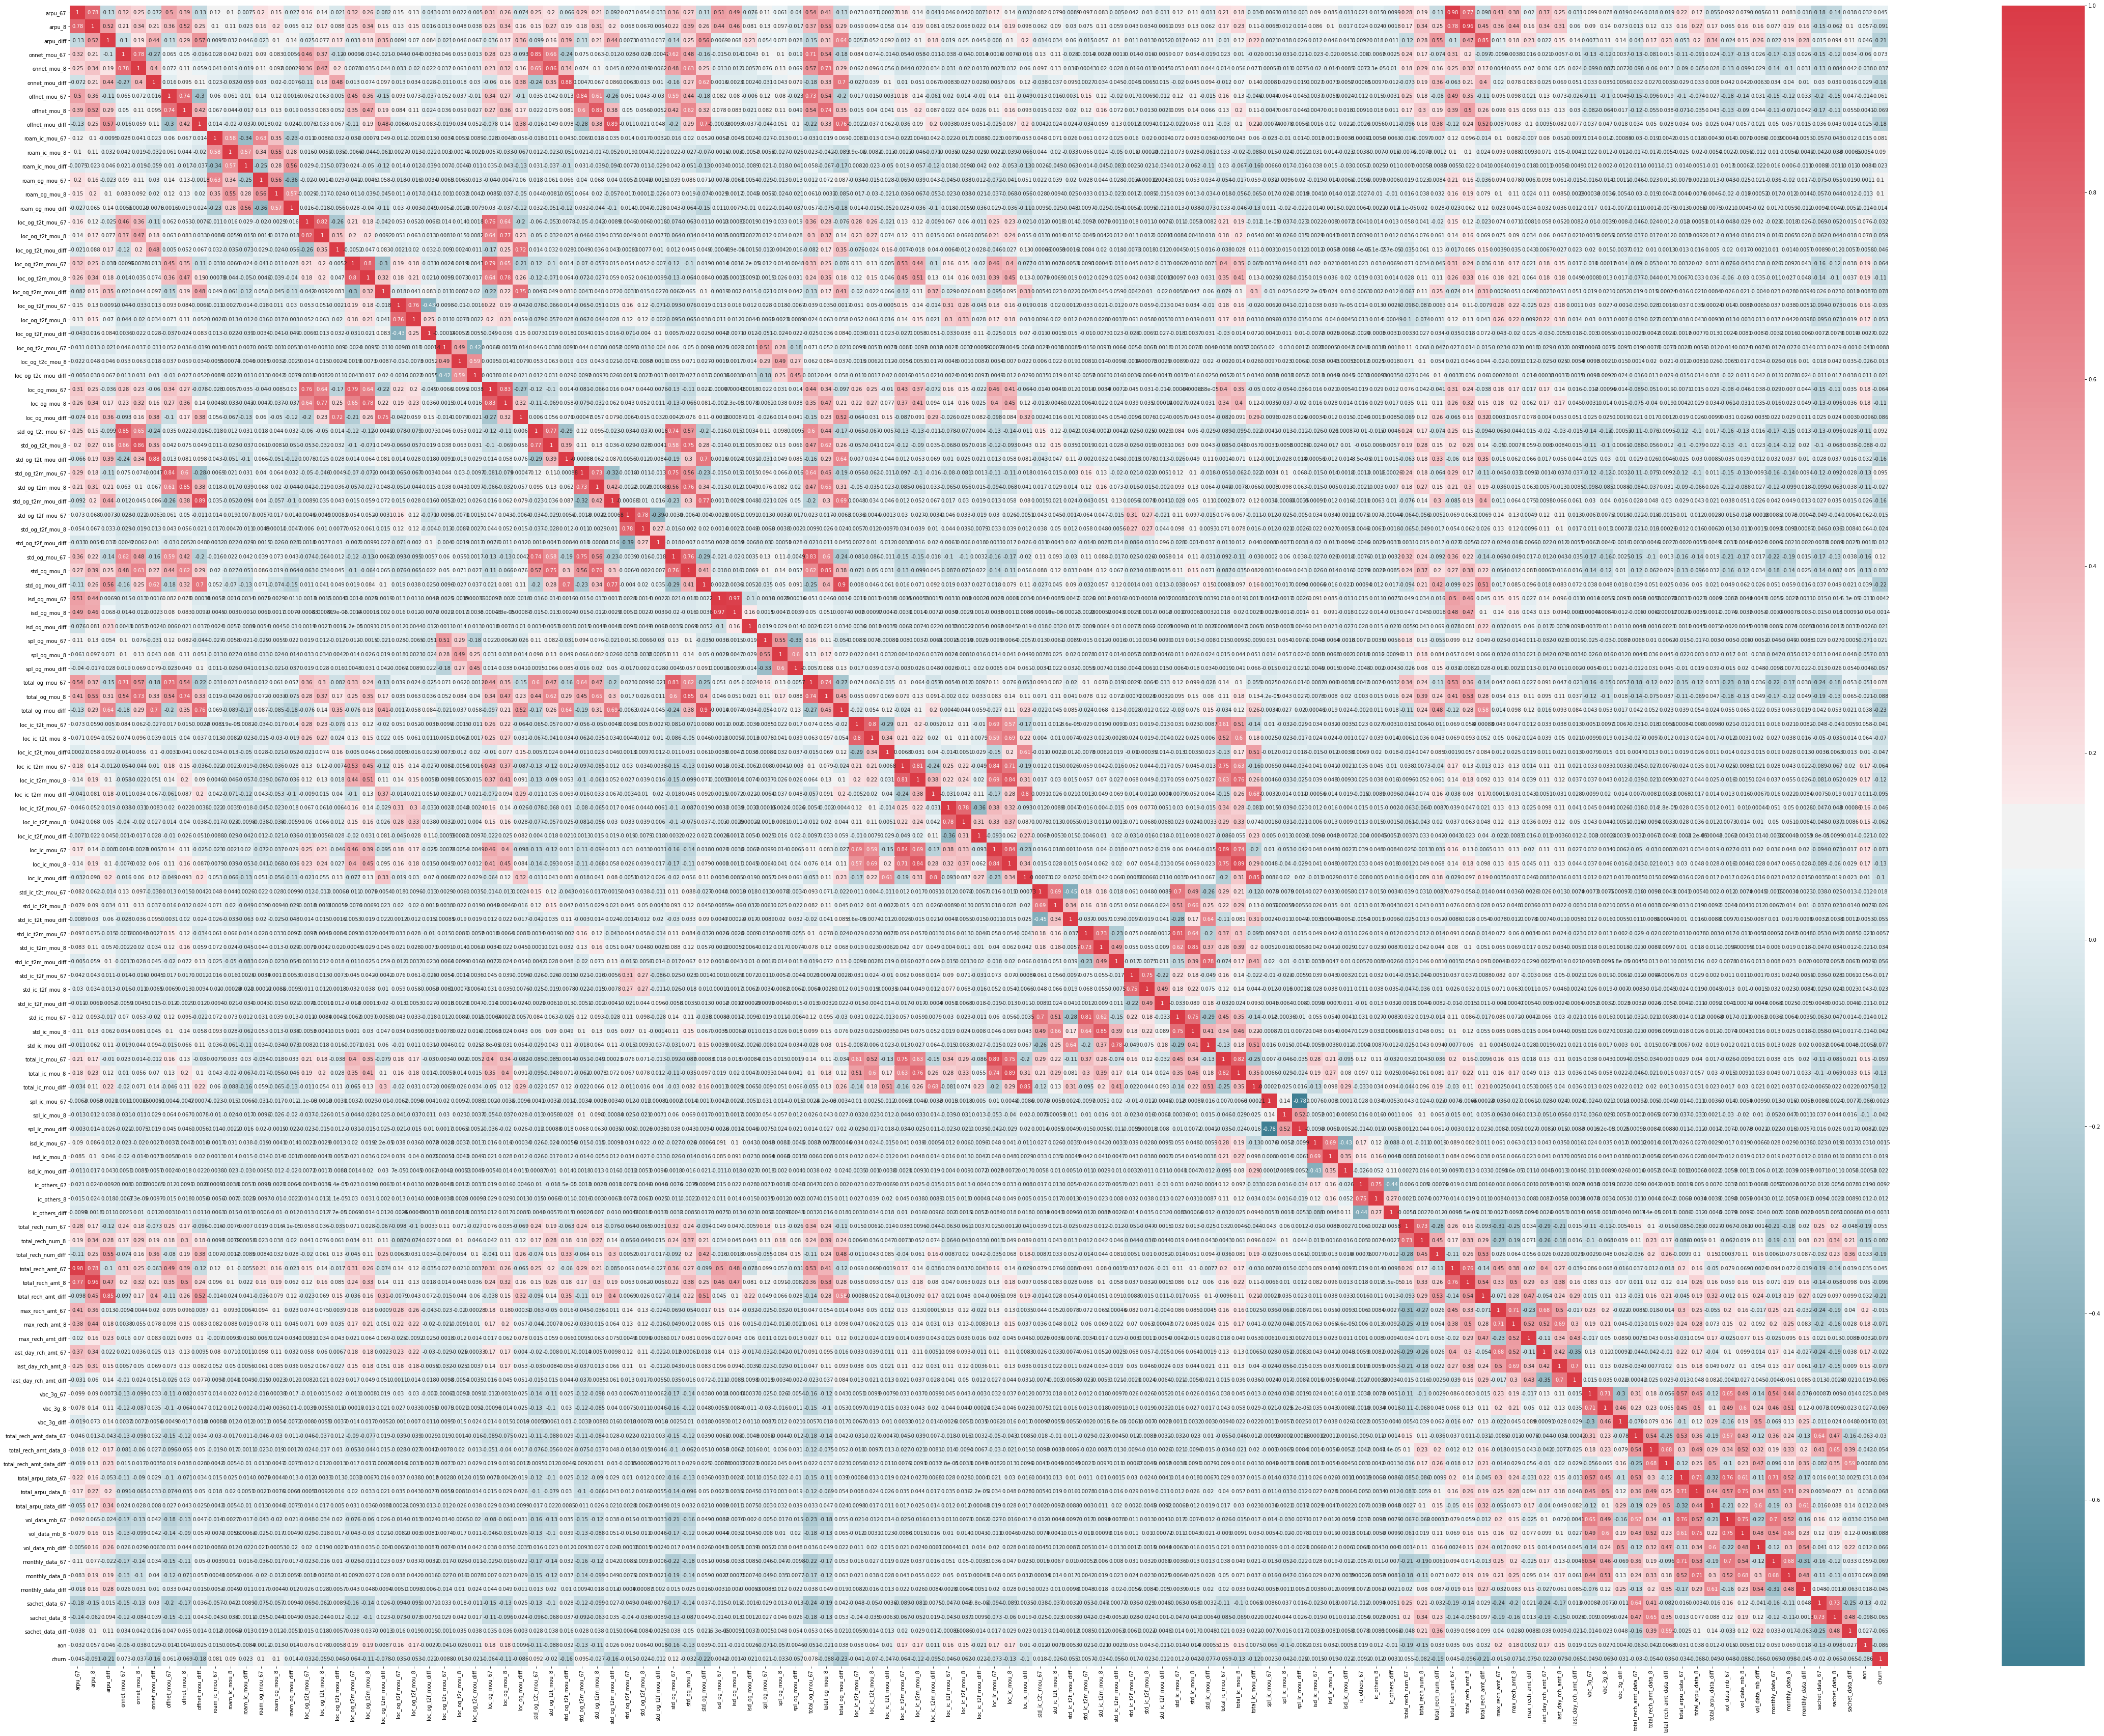

In [33]:
# Check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (80, 60))
sns.heatmap(phone.corr(), annot = True, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

# Double click to zoom into the plot see the correlation coefficients

One can see interesting observations such as:
- ARPU (Average Revenue Per User) is strongly correlated with the Total Recharge Amount
- ARPU (Average Revenue Per User) is good correlated with the Total Outgoing Call Minutes
- Total values are good correlated with their individual values (for example total minutes is good correlated with onnet minutes)
- Outgoing minutes are good correlated with their individual values (for example, with t2t outgoing minutes)
- VBC (Volume based cost) for 3G is strongly correlated with 3G data columns
- AON (Age on Network) is not strongly correlated with any of the other columns

### Visualizing Numeric Variables

As there are too many numerical columns, only few difference columns are selected to analyze the relation between each other

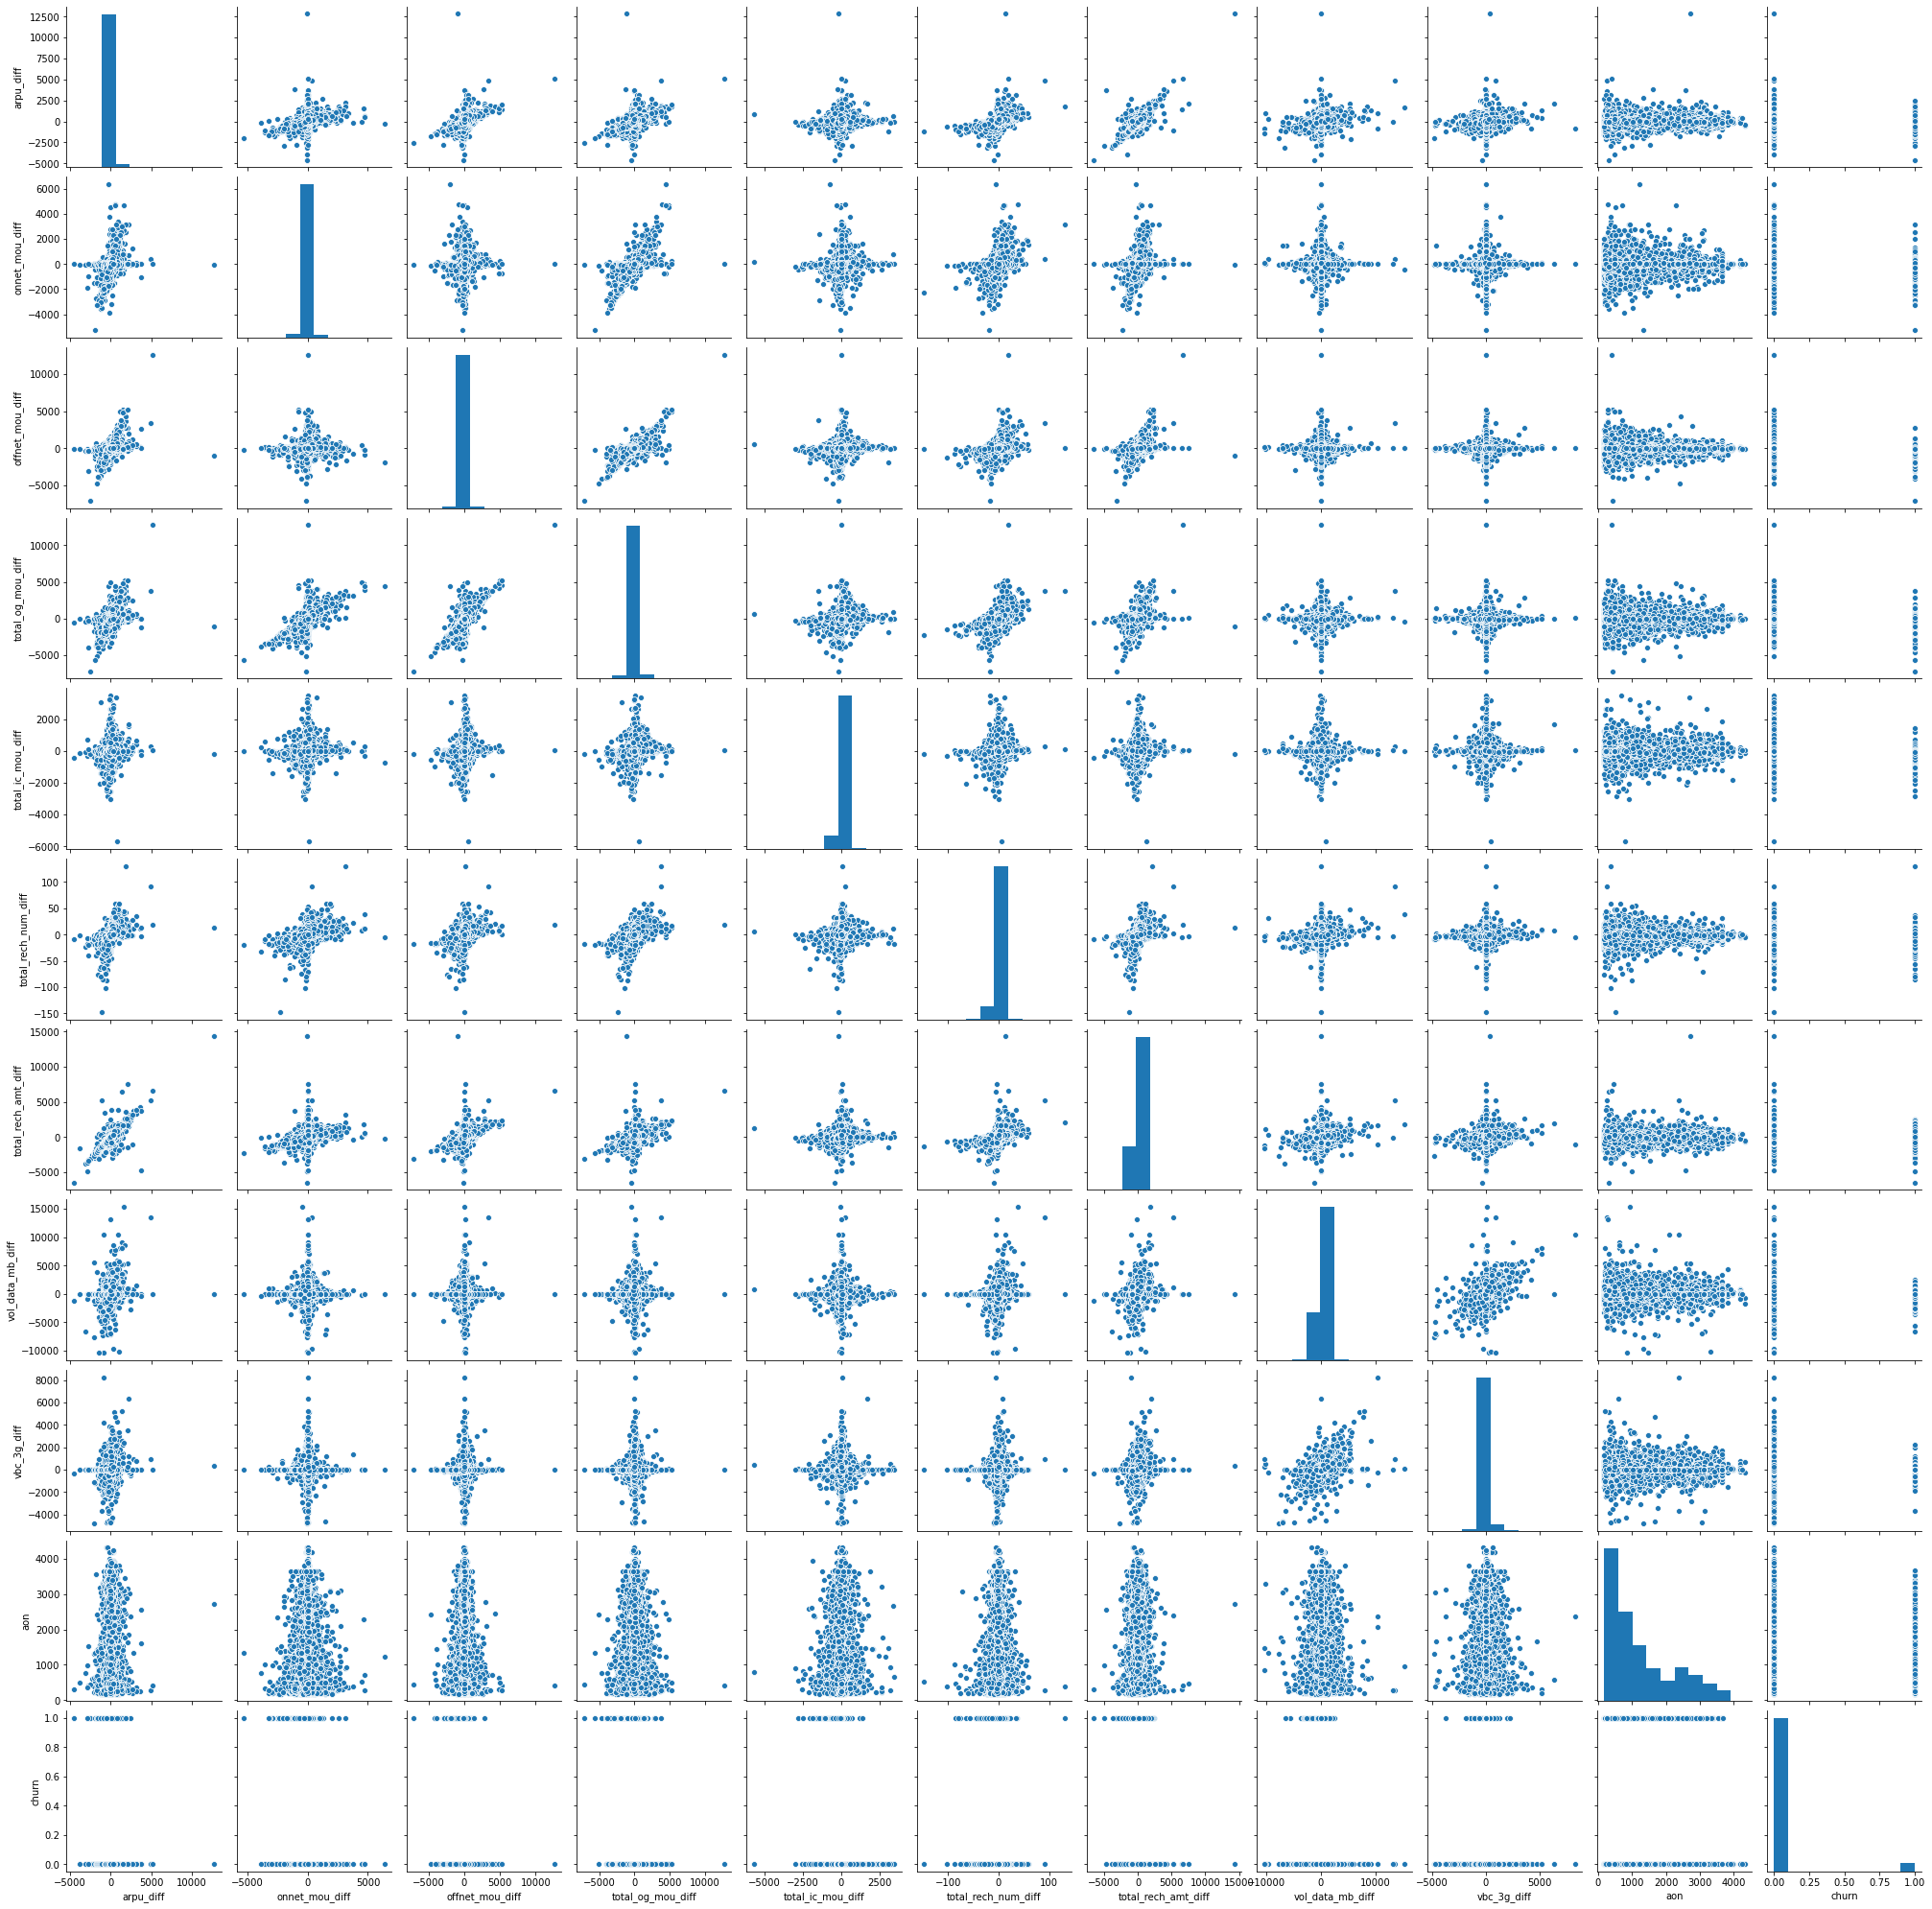

In [34]:
# Get some columns showing difference between Good Phase and Action Phase. Also include the 'aon' column
sns.pairplot(phone, vars = ['arpu_diff','onnet_mou_diff','offnet_mou_diff','total_og_mou_diff','total_ic_mou_diff',
                            'total_rech_num_diff','total_rech_amt_diff','vol_data_mb_diff','vbc_3g_diff','aon','churn'])
plt.show()

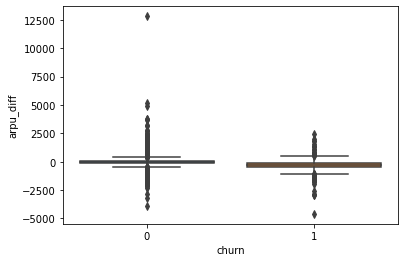

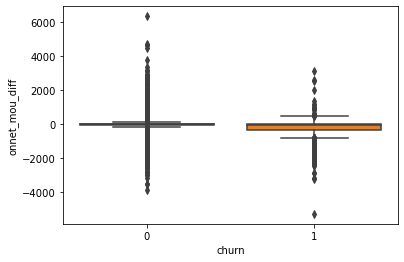

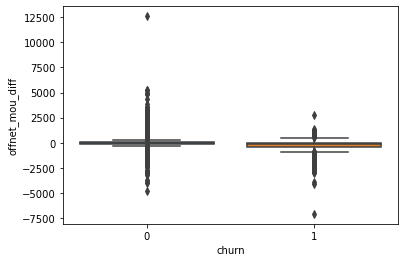

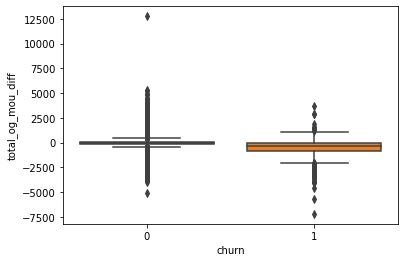

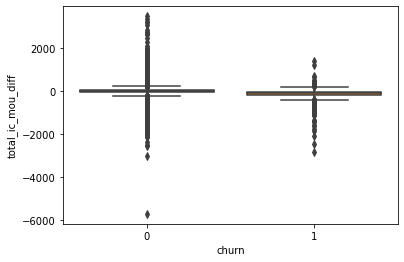

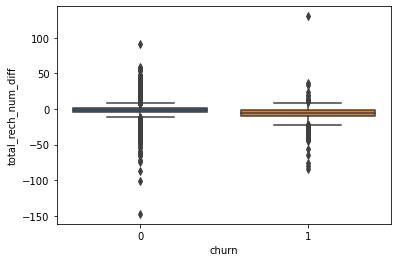

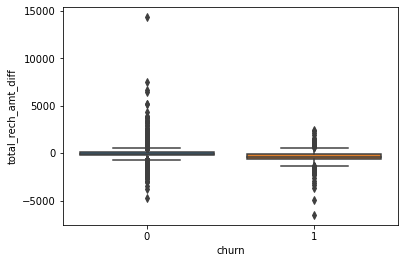

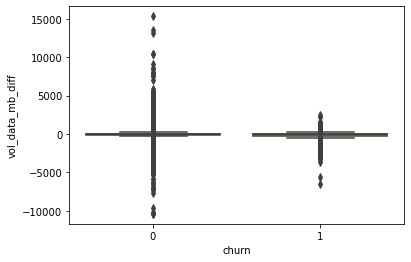

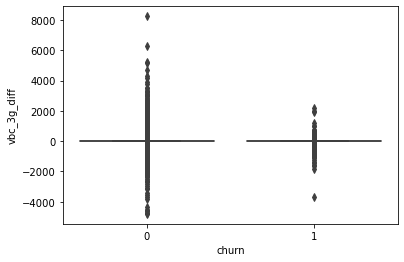

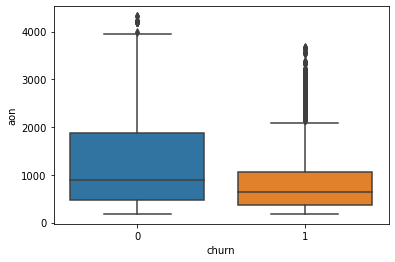

In [35]:
# Get some columns showing difference between Good Phase and Action Phase. Also include the 'aon' column
# See how churn gets affected
col_boxplot = ['arpu_diff','onnet_mou_diff','offnet_mou_diff','total_og_mou_diff','total_ic_mou_diff','total_rech_num_diff',
               'total_rech_amt_diff','vol_data_mb_diff','vbc_3g_diff','aon']

# Draw boxplots of the difference variables
for col in col_boxplot:
    sns.boxplot(phone['churn'], phone[col])
    plt.show()

Scatter plots and Box plots show some good insights:
- There is a nice grouping in case of many columns which means they are good correlated with each other
- Each plot seems have few distinct points which lie outside the groupings showing outliers
- These outliers can be treated

### Outliers Treatment

- Values beyond 99.9% and 0.01% percentiles shall be removed

In [36]:
phone.describe()

arpu_67        arpu_8     arpu_diff  onnet_mou_67   onnet_mou_8  \
count  28119.000000  28119.000000  28119.000000  28119.000000  28119.000000   
mean     567.510139    529.340820    -38.169319    271.380903    246.532381   
std      432.038596    500.713039    314.950438    443.286701    465.669094   
min     -451.713500   -345.129000  -4598.711500      0.000000      0.000000   
25%      355.850250    258.314000   -164.710750     23.950000     15.380000   
50%      490.873000    445.661000    -34.051000     98.555000     75.190000   
75%      682.709750    675.428500     87.735250    318.035000    260.500000   
max    31438.461000  33543.624000  12808.617000   7331.060000  10752.560000   

       onnet_mou_diff  offnet_mou_67  offnet_mou_8  offnet_mou_diff  \
count    28119.000000   28119.000000  28119.000000     28119.000000   
mean       -24.848522     385.001235    351.240056       -33.761178   
std        304.349568     458.558998    482.739259       341.824499   
min      -5295.315000       0.000000      0.000000     -7094.390000   
25%        -51.425000      92.025000     62.090000       -96.805000   
50%         -3.235000     246.770000    202.180000       -10.645000   
75%         21.097500     508.660000    459.195000        45.707500   
max       6359.920000    8314.795000  14007.340000     12604.240000   

       roam_ic_mou_67  roam_ic_mou_8  roam_ic_mou_diff  roam_og_mou_67  \
count    28119.000000   28119.000000      28119.000000    28119.000000   
mean        14.639674      13.157579         -1.482096       23.769919   
std         66.439040      76.179348         66.116250       94.496469   
min          0.000000       0.000000      -1296.985000        0.000000   
25%          0.000000       0.000000          0.000000        0.000000   
50%          0.000000       0.000000          0.000000        0.000000   
75%          1.717500       0.000000          0.000000        3.355000   
max       3060.600000    4169.810000       2330.200000     2410.835000   

       roam_og_mou_8  roam_og_mou_diff  loc_og_t2t_mou_67  loc_og_t2t_mou_8  \
count   28119.000000      28119.000000       28119.000000      28119.000000   
mean       20.950316         -2.819603          88.377203         82.457870   
std       107.803297         95.448913         227.077583        233.578689   
min         0.000000      -2410.835000           0.000000          0.000000   
25%         0.000000          0.000000           7.667500          4.240000   
50%         0.000000          0.000000          28.790000         23.960000   
75%         0.000000          0.000000          83.055000         77.395000   
max      5337.040000       3057.150000        5941.565000      10752.560000   

       loc_og_t2t_mou_diff  loc_og_t2m_mou_67  loc_og_t2m_mou_8  \
count         28119.000000       28119.000000      28119.000000   
mean             -5.919333         168.210878        159.381671   
std             139.905277         233.212560        235.092407   
min           -3875.375000           0.000000          0.000000   
25%             -16.615000          27.885000         18.680000   
50%              -1.070000          87.920000         76.580000   
75%               9.355000         218.577500        208.035000   
max            6412.690000        4150.165000       4961.330000   

       loc_og_t2m_mou_diff  loc_og_t2f_mou_67  loc_og_t2f_mou_8  \
count         28119.000000       28119.000000      28119.000000   
mean             -8.829206           6.576174          6.153570   
std             146.407669          21.343823         19.918596   
min           -2863.535000           0.000000          0.000000   
25%             -38.092500           0.000000          0.000000   
50%              -3.035000           0.730000          0.080000   
75%              23.885000           4.980000          4.310000   
max            3158.700000        1331.230000        928.490000   

       loc_og_t2f_mou_diff  loc_og_t2c_mou_67  loc_og_t2c_mou_8  \
count 

In [37]:
phone.shape

(28119, 119)

In [38]:
# Remove the outliers above 99.9% and below 0.01% percentiles

# Get the phone columns excepy churn
phone_cols = phone.columns
phone_cols = phone_cols.drop('churn')

phone_outlier = pd.DataFrame()

# Get the 99.9% ans 0.01% percentiles first
for col in phone_cols:
    colname = col+'_max'
    # Delete only those outliers which are above 99.9% percentile
    phone_outlier.loc[0, colname] = phone[col].quantile(0.999)
    colname = col+'_min'
    # Delete only those outliers which are below 0.01% percentile
    phone_outlier.loc[0, colname] = phone[col].quantile(0.001)

# Now delete outliers from the dataframe
for col in phone_cols:
    # Delete outliers at the upper end
    phone = phone[phone[col] < phone_outlier.loc[0, col+'_max']]
    # Delete outliers at the bottom end only if they are negative i.e. 
    # most of the columns have min as 0. Deleting them would be wrong
    if phone_outlier.loc[0, col+'_min'] < 0:
        phone = phone[phone[col] > phone_outlier.loc[0, col+'_min']]
        
phone.shape

(26128, 119)

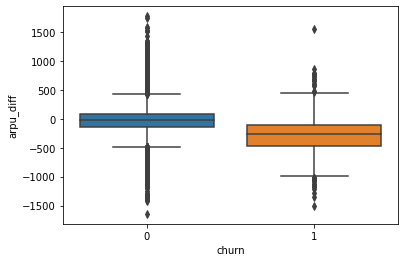

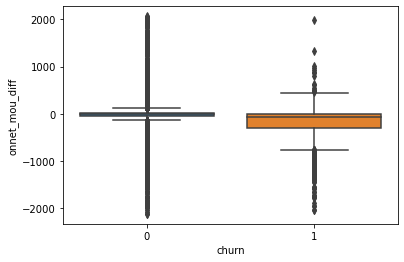

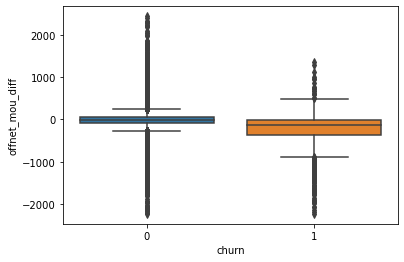

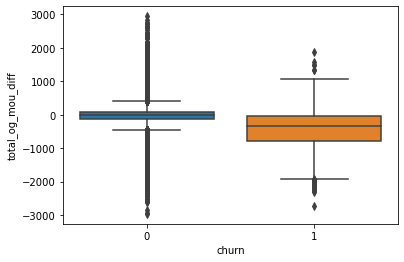

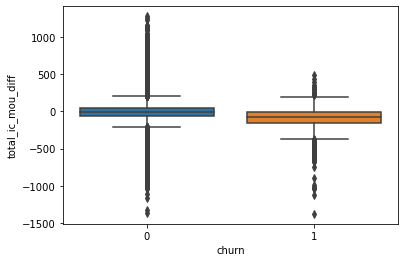

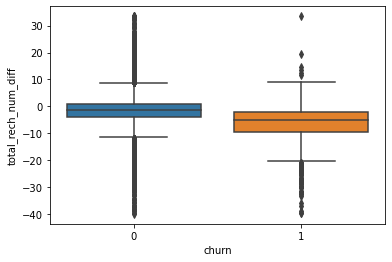

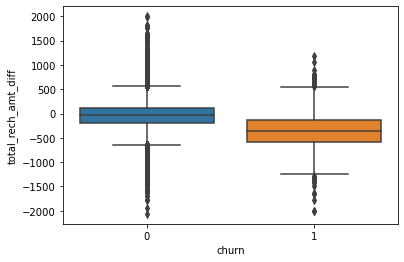

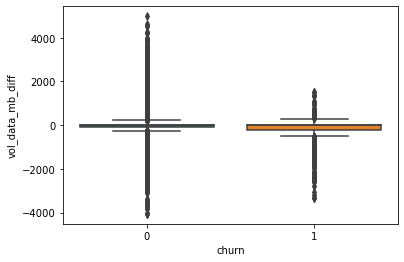

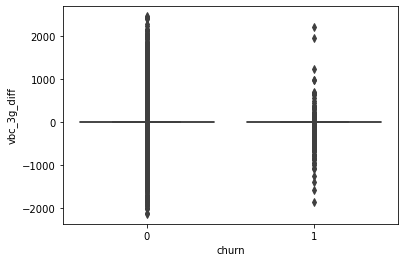

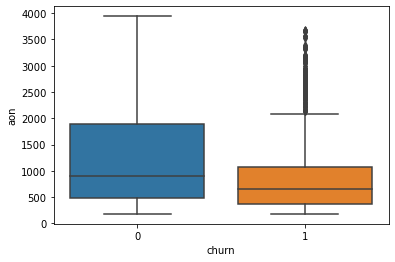

In [39]:
# See the effect or removal of outliers in boxplot
# Get some columns showing difference between Good Phase and Action Phase. Also include the 'aon' column
# See how churn gets affected
col_boxplot = ['arpu_diff','onnet_mou_diff','offnet_mou_diff','total_og_mou_diff','total_ic_mou_diff','total_rech_num_diff',
               'total_rech_amt_diff','vol_data_mb_diff','vbc_3g_diff','aon']

# Draw boxplots of the difference variables
for col in col_boxplot:
    sns.boxplot(phone['churn'], phone[col])
    plt.show()

Now the outliers are treated, let us proceed to model building

## Step 3: Building models using PCA to predict Churn

- First build several models after doing PCA
- Choose the best model out of them to predict the customer churn

### Splitting the Data into Training and Testing Sets

 Perform a train-test split

In [40]:
# Get independent and dependent variables
phone_X = phone.loc[: , phone.columns != 'churn']
phone_y = phone.loc[: , phone.columns == 'churn']

# Specify the seed so that the train and test data set always have the same rows, respectively
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(phone_X, phone_y, train_size = 0.7, test_size = 0.3, 
                                                    stratify = phone_y, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(18289, 118)
(7839, 118)


### Rescaling the Features  

Standard scaling is used to scale the model

In [41]:
# Apply standardization scaling
scaler = StandardScaler()

# Apply scaler() to all the columns
scaler.fit(X_train)
X_train[:] = scaler.transform(X_train[:])

# Apply the scaler to the test data set too
X_test[:] = scaler.transform(X_test[:])

X_train.head()

arpu_67    arpu_8  arpu_diff  onnet_mou_67  onnet_mou_8  \
17641  0.067122  0.455093   0.547091     -0.365527     0.039193   
33389 -0.224932 -0.896671  -0.969765     -0.572363    -0.573876   
3831  -0.542994 -0.000670   0.632820     -0.659987    -0.533411   
78682 -0.202896 -0.064338   0.148385     -0.571156    -0.383194   
94859  0.228216  0.390841   0.270774     -0.532810    -0.409501   

       onnet_mou_diff  offnet_mou_67  offnet_mou_8  offnet_mou_diff  \
17641        0.631179       1.776473      2.660930         1.362330   
33389       -0.012027       0.801620     -0.020317        -1.201192   
3831         0.188206      -0.723711     -0.249097         0.686712   
78682        0.286371       1.071297      0.943844        -0.161225   
94859        0.185204       1.768061      2.053895         0.471836   

       roam_ic_mou_67  roam_ic_mou_8  roam_ic_mou_diff  roam_og_mou_67  \
17641       -0.264607       -0.21762          0.043013       -0.282021   
33389       -0.264607       -0.21762          0.043013       -0.282021   
3831        -0.264607       -0.21762          0.043013       -0.282021   
78682       -0.264607       -0.21762          0.043013       -0.282021   
94859       -0.264607       -0.21762          0.043013       -0.282021   

       roam_og_mou_8  roam_og_mou_diff  loc_og_t2t_mou_67  loc_og_t2t_mou_8  \
17641       -0.23375          0.044275          -0.352787         -0.230849   
33389       -0.23375          0.044275          -0.272762         -0.420456   
3831        -0.23375          0.044275          -0.450913         -0.326829   
78682       -0.23375          0.044275          -0.276382         -0.136457   
94859       -0.23375          0.044275          -0.182068         -0.051887   

       loc_og_t2t_mou_diff  loc_og_t2m_mou_67  loc_og_t2m_mou_8  \
17641             0.260130          -0.731599         -0.586640   
33389            -0.225853          -0.596488         -0.692753   
3831              0.276423          -0.438482          0.337941   
78682             0.282130           0.108946          0.247397   
94859             0.252918           0.081183          0.396829   

       loc_og_t2m_mou_diff  loc_og_t2f_mou_67  loc_og_t2f_mou_8  \
17641             0.238686          -0.344646         -0.297794   
33389            -0.176798          -0.397647         -0.380979   
3831              1.337248          -0.397647         -0.380979   
78682             0.241619          -0.397647         -0.380979   
94859             0.548028           2.690359          2.040405   

       loc_og_t2f_mou_diff  loc_og_t2c_mou_67  loc_og_t2c_mou_8  \
17641             0.088127           0.498396          4.226769   
33389             0.040439          -0.339414         -0.309395   
3831              0.040439          -0.376784         -0.309395   
78682             0.040439           0.881739          2.179317   
94859            -1.153466          -0.376784         -0.309395   

       loc_og_t2c_mou_diff  loc_og_mou_67  loc_og_mou_8  loc_og_mou_diff  \
17641             3.712476      -0.709938     -0.542835         0.325929   
33389            -0.032355      -0.575683     -0.723490        -0.254724   
3831             -0.002823      -0.573189      0.034779         1.129770   
78682             1.420422      -0.105825      0.077072         0.338014   
94859            -0.002823       0.074648      0.338668         0.481597   

       std_og_t2t_mou_67  std_og_t2t_mou_8  std_og_t2t_mou_diff  \
17641          -0.198147          0.171225             0.573160   
33389          -0.467862         -0.411942             0.075750   
3831           -0.472457         -0.411942             0.082827   
78682          -0.464657         -0.337344             0.187577   
94859          -0.471096         -0.406361             0.089467   

       std_og_t2m_mou_67  std_og_t2m_mou_8  std_og_t2m_mou_diff  \
17641           2.503490          3.454918             1.381074   
33389           1.337676          0.456772            -

In [42]:
# Check the data imbalance i.e the churn vs non-churn ratio
phone['churn'].value_counts(1) * 100

0    94.745101
1     5.254899
Name: churn, dtype: float64

We have 95% churn cases and only 5% of non-churn cases. This is balanced using class weights during model building phase

### PCA

- Perform PCA for dimensionality reduction

In [43]:
# Peform PCA for dimensionality reduction
pca = PCA(random_state = 100)

# Apply PCA on train data
X_train_pca = pca.fit_transform(X_train)
print(X_train_pca.shape)

# Apply PCA on test data
X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(18289, 118)
(7839, 118)


In [44]:
testpca = PCA(0.9, random_state = 100)
X_train_testpca = testpca.fit_transform(X_train)

In [45]:
X_train_testpca.shape

(18289, 41)

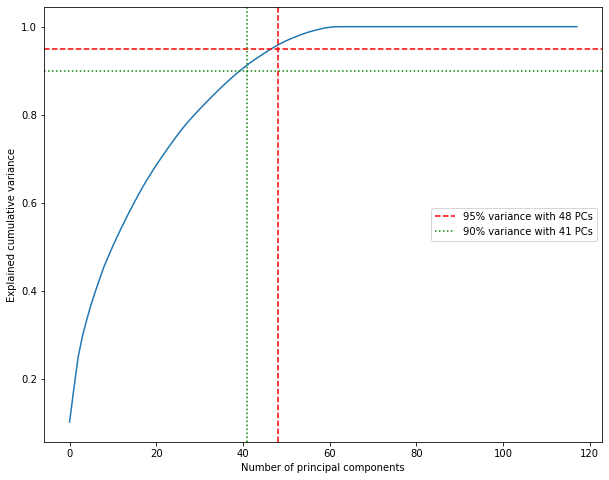

In [46]:
# Scree plot to check the variance explained by different PCs
fig = plt.figure(figsize = (10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.axhline(0.95, c = 'r', label = '95% variance with 48 PCs', linestyle ='--')
plt.axvline(48, c = 'r', linestyle ='--')
plt.axhline(0.90, c = 'g', label = '90% variance with 41 PCs', linestyle =':')
plt.axvline(41, c = 'g', linestyle =':')
plt.legend(loc = 'center right')
plt.ylabel('Explained cumulative variance')
plt.show()

In [47]:
# Cumulative explained variance
np.cumsum(pca.explained_variance_ratio_)

array([0.10235034, 0.17891367, 0.25079496, 0.29832344, 0.33599231,
       0.37034144, 0.40044614, 0.42890931, 0.45669303, 0.4797325 ,
       0.50233629, 0.52362521, 0.54422379, 0.56426328, 0.58346928,
       0.6023544 , 0.6206357 , 0.63812169, 0.65466904, 0.67047249,
       0.6856573 , 0.70026077, 0.71458882, 0.72848557, 0.7423207 ,
       0.75564825, 0.76815295, 0.78025489, 0.79135988, 0.80219442,
       0.81270489, 0.82291879, 0.83301659, 0.84291743, 0.85268231,
       0.86218205, 0.8715102 , 0.88041799, 0.88920119, 0.89754536,
       0.90565572, 0.91314108, 0.92048829, 0.92721799, 0.93381652,
       0.94025004, 0.94657523, 0.95264052, 0.95837839, 0.96337914,
       0.96821004, 0.97248786, 0.97648711, 0.98040649, 0.98402124,
       0.98741275, 0.99020358, 0.99268676, 0.99512235, 0.99726549,
       0.99859776, 0.99972916, 0.99990921, 0.99997003, 0.99999785,
       0.99999902, 0.99999962, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

- About 41 Principal Components explain Variance of 90%
- About 48 Principal Components explain Variance of 95%

In [48]:
# Create a dataset with 41 Principal Components, i.e., 90% variance for builing the models here on
# Peform PCA for dimensionality reduction
pca = PCA(0.90, random_state = 100)

# Apply PCA on train data
X_train_pca = pca.fit_transform(X_train)
print(X_train_pca.shape)

# Apply PCA on test data
X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(18289, 41)
(7839, 41)


### Custom function to plot ROC Curve

- Define a custom function which would be repeatedly used in the model building process to plot the ROC curve

In [49]:
# Printing ROC curve
def draw_roc( actual_train, probs_train, actual_test, probs_test):
    fpr, tpr, thresholds = metrics.roc_curve( actual_train, probs_train,
                                              drop_intermediate = False )
    auc_score_train = metrics.roc_auc_score( actual_train, probs_train )
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score_train )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Train ROC')
    plt.legend(loc="lower right")
    
    fpr, tpr, thresholds = metrics.roc_curve( actual_test, probs_test,
                                              drop_intermediate = False )
    auc_score_test = metrics.roc_auc_score( actual_test, probs_test )
    plt.subplot(1,2,2)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score_test )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC')
    plt.legend(loc="lower right")

### Logistic regression with PCA

- Let us build a Logistic Regression Model using 41 (90% variance) Principal components and select the best out of them

In [50]:
# Logistic Regression Model
log_pca = LogisticRegression(random_state = 100)

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Select class_weight to handle imbalance in data
weights = np.linspace(0.01, 0.02, 5)
classWeights = [{0:x, 1:1.0-x} for x in weights]

# Select Hyperparameters -> Logistic Regularization parameter (C) and the Regularization (L1 or L2)
log_params = {'C': [0.1, 0.2, 0.5, 1], 'penalty': ['l1', 'l2'], 'solver':['liblinear', 'saga'],
             'class_weight': classWeights}

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Create Gridsearch Cross Validation object
log_model = GridSearchCV(estimator = log_pca, cv = folds, param_grid = log_params, scoring = scoring, 
                         refit = 'f1score', n_jobs = -1, verbose = 1, return_train_score = True)

# Fit the Logistic Regression model
log_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(random_state=100), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1],
                         'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.0125, 1: 0.9875},
                                          {0: 0.015, 1: 0.985},
                                          {0: 0.0175, 1: 0.9825},
                                          {0: 0.02, 1: 0.98}],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             refit='f1score', return_train_score=True,
             scoring={'f1score': 'f1', 'recall': 'recall'}, verbose=1)

In [51]:
# Get best hyperparameters
print('Best F1 Score:        ', log_model.best_score_)
print('Best hyperparameters: ', log_model.best_params_)

Best F1 Score:         0.17569479483020006
Best hyperparameters:  {'C': 1, 'class_weight': {0: 0.02, 1: 0.98}, 'penalty': 'l2', 'solver': 'liblinear'}


#### Final Logistic Regression model based on PCA

In [52]:
# Final Logistic Model using PCA and the parameters determined above

# Create Logistic Regression Model
log_pca_fin = LogisticRegression(solver = 'liblinear', C = 1, penalty = 'l2', class_weight = {0: 0.02, 1: 0.98})

# Fit the Logistic Regression model
log_pca_fin.fit(X_train_pca, y_train)

LogisticRegression(C=1, class_weight={0: 0.02, 1: 0.98}, solver='liblinear')

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [53]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test= log_pca_fin.predict(X_train_pca)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, log_pca_fin.predict_proba(X_train_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] =[sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.932362  0.519679  0.867891


In [54]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test= log_pca_fin.predict(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, log_pca_fin.predict_proba(X_test_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.924757  0.530362  0.872277


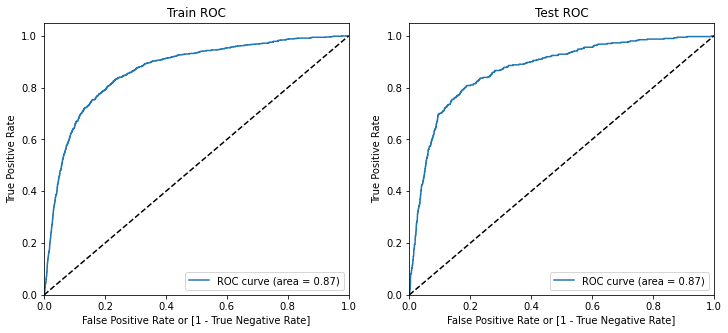

In [55]:
# Plot the ROC
draw_roc(y_train, log_pca_fin.predict_proba(X_train_pca)[:,1], y_test, log_pca_fin.predict_proba(X_test_pca)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [56]:
# Store the Sensitivity results for each model in a dataframe for final comparison
results = pd.DataFrame({'Method':['Logistic with PCA'],
                       'Sensitivity': round(sensi, 2), 'Specificity': round(speci, 2), 
                        'AUC': round(auc, 2)}, index = {'1'})
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1  Logistic with PCA         0.92         0.53  0.87

### Random Forest with PCA

- Let us build a Random Forest using 41 Principal components and select the best out of them

In [57]:
# Random Forest Model
rf_pca = RandomForestClassifier(random_state = 100)

# Select class_weight to handle imbalance in data
weights = np.linspace(0.01, 0.02, 5)
classWeights = [{0:x, 1:1.0-x} for x in weights]

# Create 5 folds
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
rf_params = {'max_depth': [5,7,10], 'min_samples_leaf': range(240, 280, 20), 'n_estimators': [100, 200],
             'max_features': ['log2', 'sqrt'], 'class_weight': classWeights}

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 Score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Instantiate the grid search model
rf_model = GridSearchCV(estimator = rf_pca, param_grid = rf_params, cv = folds, n_jobs = -1, 
                        scoring = scoring, refit = 'f1score', verbose = 1, return_train_score = True)

# Fit the Random Forest model
rf_model.fit(X_train_pca, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(random_state=100), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.0125, 1: 0.9875},
                                          {0: 0.015, 1: 0.985},
                                          {0: 0.0175, 1: 0.9825},
                                          {0: 0.02, 1: 0.98}],
                         'max_depth': [5, 7, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': range(240, 280, 20),
                         'n_estimators': [100, 200]},
             refit='f1score', return_train_score=True,
             scoring={'f1score': 'f1', 'recall': 'recall'}, verbose=1)

In [58]:
# Get best hyperparameters
print('Best F1 Score:        ', rf_model.best_score_)
print('Best hyperparameters: ', rf_model.best_params_)

Best F1 Score:         0.18970011441891077
Best hyperparameters:  {'class_weight': {0: 0.02, 1: 0.98}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 240, 'n_estimators': 200}


#### Final Random Forest model based on PCA

In [59]:
# Final Random Forest Model using PCA and the parameters determined above

# Create a RF Model
rf_pca_fin = RandomForestClassifier(max_depth = 10, min_samples_leaf = 240, n_estimators = 200,
                                    max_features = 'sqrt', class_weight = {0: 0.02, 1: 0.98}, random_state = 100)
                                  
# Fit the Random Forest model
rf_pca_fin.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight={0: 0.02, 1: 0.98}, max_depth=10,
                       max_features='sqrt', min_samples_leaf=240,
                       n_estimators=200, random_state=100)

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [60]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test= rf_pca_fin.predict(X_train_pca)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, rf_pca_fin.predict_proba(X_train_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.954214  0.610053  0.912434


In [61]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test= rf_pca_fin.predict(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
accuracy = (cm[0,0] + cm[1,1])/(sum(sum(cm)))
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, rf_pca_fin.predict_proba(X_test_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] =[sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.900485  0.617477  0.869682


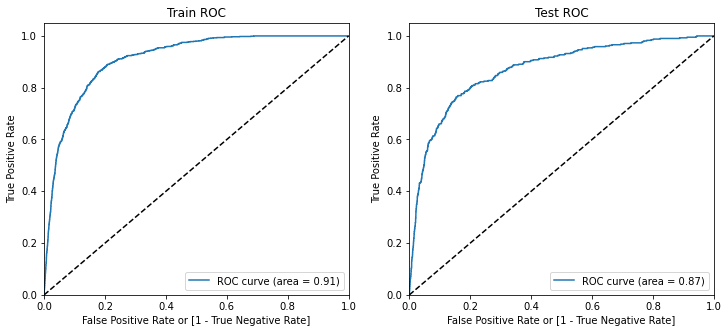

In [62]:
# Plot the ROC
draw_roc(y_train, rf_pca_fin.predict_proba(X_train_pca)[:,1], y_test, rf_pca_fin.predict_proba(X_test_pca)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [63]:
# Store the Sensitivity results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Random Forest with PCA'],'Sensitivity': round(sensi, 2), 
                              'Specificity': round(speci, 2), 'AUC': round(auc, 2)}, index = {'2'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87

### AdaBoost on Decision Tree with PCA

- Build a model using Adaptive Boosting on weak decision trees on the 41 PCs of PCA
- Now tune the hyperparameters of AdaBoost model

In [64]:
# Hyperparameter tuning of AdaBoost on Decision Tree
# Select a weak learner by restricting the max_depth to 2
dctree = DecisionTreeClassifier(max_depth = 2, random_state = 100)

# Adaboost with the tree as base estimator
# We are tuning on the learning rate, Hence the no. of trees n_estimators is fixed to 50 (both should not be tuned together)
ABC = AdaBoostClassifier(base_estimator = dctree, n_estimators = 50)

# Select class_weight to handle imbalance in data
weights = np.linspace(0.01, 0.02, 5)
classWeights = [{0:x, 1:1.0-x} for x in weights]

# Create the parameter grid 
adab_params = {'base_estimator__class_weight': classWeights, 
               'base_estimator__min_samples_leaf': range(200, 500, 200), 'learning_rate': [0.1, 0.2]}

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 Score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Create 5 folds
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

# Create Gridsearch Cross Validation object
adab_model = GridSearchCV(estimator = ABC, cv = folds, param_grid = adab_params, scoring = scoring, 
                          refit = 'f1score', return_train_score = True, n_jobs = -1, verbose = 1)

# Fit the AdaBoost model
adab_model.fit(X_train_pca, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=100, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                                random_state=100)),
             n_jobs=-1,
             param_grid={'base_estimator__class_weight': [{0: 0.01, 1: 0.99},
                                                          {0: 0.0125,
                                                           1: 0.9875},
                                                          {0: 0.015, 1: 0.985},
                                                          {0: 0.0175,
                                                           1: 0.9825},
                                                          {0: 0.02, 1: 0.98}],
                         'base_estimator__min_samples_leaf': range(200, 500, 200),
                         'learning_rate': [0.1, 0.2]},
             refit='f1score', return_train_score=

In [65]:
# Get best hyperparameters
print('Best F1 Score:        ', adab_model.best_score_)
print('Best hyperparameters: ', adab_model.best_params_)

Best F1 Score:         0.20393380293359983
Best hyperparameters:  {'base_estimator__class_weight': {0: 0.02, 1: 0.98}, 'base_estimator__min_samples_leaf': 200, 'learning_rate': 0.2}


#### Final AdaBoost model


In [66]:
# Base estimator
dctree = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 200,
                                class_weight = {0:0.02, 1:0.98}, random_state = 100)

# Final Adaboost Model using the parameters determined above
adab_pca_final = AdaBoostClassifier(base_estimator = dctree, n_estimators = 50, learning_rate = 0.2)

# Fit the AdaBoost model
adab_pca_final.fit(X_train_pca, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.02,
                                                                       1: 0.98},
                                                         max_depth=2,
                                                         min_samples_leaf=200,
                                                         random_state=100),
                   learning_rate=0.2)

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [67]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci','auc'])

y_pred_test= adab_pca_final.predict(X_train_pca)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, adab_pca_final.predict_proba(X_train_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

     sensi     speci       auc
0  0.94589  0.618479  0.906526


In [68]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test= adab_pca_final.predict(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
accuracy = (cm[0,0] + cm[1,1])/(sum(sum(cm)))
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, adab_pca_final.predict_proba(X_test_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.915049  0.622459  0.875198


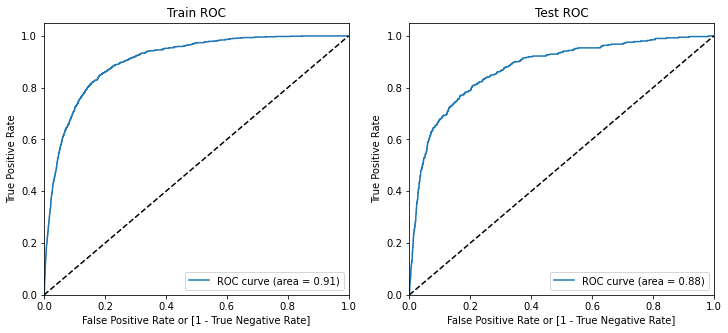

In [69]:
# Plot the ROC
draw_roc(y_train, adab_pca_final.predict_proba(X_train_pca)[:,1], y_test, adab_pca_final.predict_proba(X_test_pca)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [70]:
# Store the Sensitivity results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['AdaBoost with PCA'], 'Sensitivity': round(sensi, 2), 
                              'Specificity': round(speci, 2), 'AUC': round(auc, 2)}, index = {'3'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87
3       AdaBoost with PCA         0.92         0.62  0.88

### XGBoost on Decision Tree with PCA

- Build a model using XG Boosting on weak decision trees on the 41 PCs of PCA
- Now tune the hyperparameters of XGBoost model

In [71]:
# Hyperparameter tuning of XGBoost on Decision Tree
# Select a weak learner by restricting the max_depth to 2
# We are tuning on the learning rate, Hence the no. of trees n_estimators is fixed to 50 (both should not be tuned together)
XGB = XGBClassifier(booster = 'gbtree', n_estimator = 50, max_depth = 2, random_state = 100)

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid 
pos_Weights = np.linspace(50, 55, 5)
xgb_params = {'gamma': [50, 100], 'learning_rate': [0.1, 0.2], 'scale_pos_weight': pos_Weights}    

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 Score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Create Gridsearch Cross Validation object
xgb_model = GridSearchCV(estimator = XGB, cv = folds, param_grid = xgb_params, scoring = scoring, 
                         refit = 'f1score', return_train_score = True, n_jobs = -1, verbose = 1)

# Fit the XGBoost model
xgb_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBClassifier(max_depth=2, n_estimator=50,
                                     random_state=100),
             n_jobs=-1,
             param_grid={'gamma': [50, 100], 'learning_rate': [0.1, 0.2],
                         'scale_pos_weight': array([50.  , 51.25, 52.5 , 53.75, 55.  ])},
             refit='f1score', return_train_score=True,
             scoring={'f1score': 'f1', 'recall': 'recall'}, verbose=1)

In [72]:
# Get best hyperparameters
print('Best F1 Score:        ', xgb_model.best_score_)
print('Best hyperparameters: ', xgb_model.best_params_)

Best F1 Score:         0.21914494862882744
Best hyperparameters:  {'gamma': 50, 'learning_rate': 0.2, 'scale_pos_weight': 50.0}


#### Final XGBoost model


In [73]:
# Final XGBoost Model using the parameters determined above
xgb_pca_final = XGBClassifier(booster = 'gbtree', max_depth = 2, n_estimators = 50, 
                              learning_rate = 0.2, scale_pos_weight = 50, gamma = 50, random_state = 100)

# Fit the XGBoost model
xgb_pca_final.fit(X_train_pca, y_train)

XGBClassifier(gamma=50, learning_rate=0.2, max_depth=2, n_estimators=50,
              random_state=100, scale_pos_weight=50)

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [74]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi', 'speci', 'auc'])

y_pred_test= xgb_pca_final.predict(X_train_pca)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, xgb_pca_final.predict_proba(X_train_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

     sensi     speci       auc
0  0.94589  0.612304  0.904838


In [75]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi', 'speci', 'auc'])

y_pred_test= xgb_pca_final.predict(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, xgb_pca_final.predict_proba(X_test_pca)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.912621  0.620035  0.876778


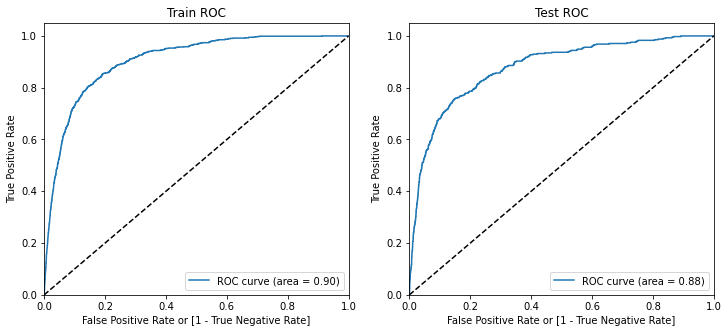

In [76]:
# Plot the ROC
draw_roc(y_train, xgb_pca_final.predict_proba(X_train_pca)[:,1], y_test, xgb_pca_final.predict_proba(X_test_pca)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [77]:
# Store the Sensitivity results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'Sensitivity': round(sensi, 2), 
                              'Specificity': round(speci, 2), 'AUC': round(auc, 2)}, index = {'4'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87
3       AdaBoost with PCA         0.92         0.62  0.88
4                 XGBoost         0.91         0.62  0.88

## Step 4: Building models without PCA to identify important predictors

- Second part of the problem is to to identify the important predictors contributing to the churn 
- Build a Logistic Regression Model after RFE to arrive at important predictors which decide the customer churn
- Build a Decision Tree Model to arrive at important predictors which decide the customer churn
- Select the best model out of the two

### RFE to trim down the number of predictors

- Use RFECV() package from sklearn to find the optimum number of features

In [78]:
# RFECV to find the optimum number of features

# set up cross validation scheme with 5 splits
folds_rfe = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# RFE Cross Validation
model_log = LogisticRegression(random_state = 100)
model_log_rfe = RFECV(estimator = model_log, step = 1, cv = folds_rfe, n_jobs = -1, 
                      scoring = 'roc_auc', min_features_to_select = 1)

# Fit the model
model_log_rfe.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
      estimator=LogisticRegression(random_state=100), n_jobs=-1,
      scoring='roc_auc')

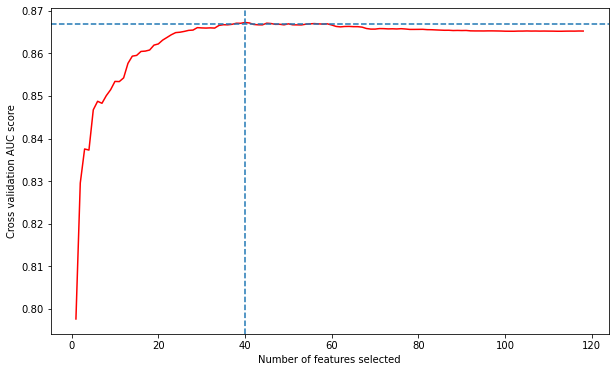

In [79]:
# RFECV results
# Plot number of features VS. cross-validation scores
plt.figure(figsize = (10,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation AUC score')
plt.plot(range(1, len(model_log_rfe.grid_scores_) + 1), model_log_rfe.grid_scores_, color = 'r')
plt.axvline(40, linestyle = '--')
plt.axhline(0.867, linestyle = '--')
plt.show()

In [80]:
model_log_rfe.grid_scores_

array([0.79765617, 0.82957064, 0.83757   , 0.83730767, 0.84675942,
       0.84876547, 0.84829279, 0.85008189, 0.85147854, 0.85342833,
       0.8533874 , 0.85425803, 0.8576684 , 0.8593587 , 0.85953591,
       0.86046495, 0.86054547, 0.86079881, 0.86195068, 0.8622275 ,
       0.86312404, 0.86375027, 0.86438744, 0.8648858 , 0.86498036,
       0.86517175, 0.86541305, 0.86547909, 0.86605626, 0.86598681,
       0.86595306, 0.86600012, 0.86594714, 0.86657868, 0.86673418,
       0.86671257, 0.86683337, 0.86708657, 0.86707127, 0.86726783,
       0.86715596, 0.8667979 , 0.86671793, 0.86670139, 0.86709988,
       0.86701453, 0.86682616, 0.8668427 , 0.86671074, 0.86694518,
       0.86671828, 0.86670468, 0.86668839, 0.86686056, 0.8669448 ,
       0.8670044 , 0.86693407, 0.86688383, 0.86694335, 0.86667033,
       0.86633555, 0.8662319 , 0.86632239, 0.86634168, 0.86628297,
       0.86628356, 0.86617082, 0.86584907, 0.86571048, 0.86571017,
       0.86583131, 0.86581597, 0.86575845, 0.8657813 , 0.86574

- From the plot, the AUC value settles from 40th feature onwards. 
- So build a Logistic Regression model using 40 features

In [81]:
# Run RFE with 40 Features first
logreg = LogisticRegression(random_state = 100)
rfe = RFE(logreg, 40)            
rfe = rfe.fit(X_train, y_train)

# Creating X_train dataframe with RFE selected variables
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
print(X_train_rfe.shape)

# Creating X_test dataframe with RFE selected variables
X_test_rfe = X_test[col]
print(X_test_rfe.shape)

(18289, 40)
(7839, 40)


In [82]:
# See which columns have been eliminated by RFE and their ranking
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_67', True, 1),
 ('arpu_8', True, 1),
 ('arpu_diff', False, 8),
 ('onnet_mou_67', False, 32),
 ('onnet_mou_8', False, 33),
 ('onnet_mou_diff', False, 3),
 ('offnet_mou_67', True, 1),
 ('offnet_mou_8', False, 12),
 ('offnet_mou_diff', True, 1),
 ('roam_ic_mou_67', False, 7),
 ('roam_ic_mou_8', False, 51),
 ('roam_ic_mou_diff', False, 52),
 ('roam_og_mou_67', False, 36),
 ('roam_og_mou_8', True, 1),
 ('roam_og_mou_diff', False, 61),
 ('loc_og_t2t_mou_67', False, 34),
 ('loc_og_t2t_mou_8', False, 41),
 ('loc_og_t2t_mou_diff', False, 40),
 ('loc_og_t2m_mou_67', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2m_mou_diff', True, 1),
 ('loc_og_t2f_mou_67', False, 9),
 ('loc_og_t2f_mou_8', False, 31),
 ('loc_og_t2f_mou_diff', False, 79),
 ('loc_og_t2c_mou_67', False, 68),
 ('loc_og_t2c_mou_8', False, 67),
 ('loc_og_t2c_mou_diff', False, 21),
 ('loc_og_mou_67', False, 11),
 ('loc_og_mou_8', False, 56),
 ('loc_og_mou_diff', False, 69),
 ('std_og_t2t_mou_67', False, 13),
 ('std_og_t2

### Logistic Regression with RFE

- Now tune the hyperparameters of Logistic Regression model built on 40 features

In [84]:
# Hyperparameter tuning of Logistic Regression

# We have chosen L1 regularization as it will automatically choose some features by nullifying coefficients of some variables
logit = LogisticRegression(penalty='l1', random_state = 100)

# Select Hyperparameters -> class_weight to handle imbalance in data
weights = np.linspace(0.01, 0.03, 5)
classWeights = [{0:x, 1:1.0-x} for x in weights]

# Select Hyperparameters -> Logistic Regularization parameter (C)
log_params = {'C': [0.1, 0.2, 0.5],  'solver':['liblinear', 'saga'], 'class_weight': classWeights}

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 Score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create Gridsearch Cross Validation object
log_model = GridSearchCV(estimator = logit, cv = folds, param_grid = log_params, n_jobs = -1, 
                         scoring = scoring, refit = 'f1score', verbose = 1, return_train_score = True)

# Fit the Logistic Regression model
log_model.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=100),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5],
                         'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.015, 1: 0.985},
                                          {0: 0.019999999999999997, 1: 0.98},
                                          {0: 0.024999999999999998, 1: 0.975},
                                          {0: 0.03, 1: 0.97}],
                         'solver': ['liblinear', 'saga']},
             refit='f1score', return_train_score=True,
             scoring={'f1score': 'f1', 'recall': 'recall'}, verbose=1)

In [85]:
# Get best hyperparameters
print('Best F1 Score:        ', log_model.best_score_)
print('Best hyperparameters: ', log_model.best_params_)

Best F1 Score:         0.2173890706417272
Best hyperparameters:  {'C': 0.5, 'class_weight': {0: 0.03, 1: 0.97}, 'solver': 'saga'}


#### Final Logistic Regression model based on RFE

In [86]:
# Final Logistic Model using RFE and the parameters determined above
log_final = LogisticRegression(solver = 'saga', C = 0.5, penalty = 'l1', class_weight = {0: 0.03, 1: 0.97})

# Fit the Logistic Regression model
log_final.fit(X_train_rfe, y_train)

LogisticRegression(C=0.5, class_weight={0: 0.03, 1: 0.97}, penalty='l1',
                   solver='saga')

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [87]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci','auc'])

y_pred_test = log_final.predict(X_train_rfe)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, log_final.predict_proba(X_train_rfe)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci      auc
0  0.893861  0.652701  0.87617


In [88]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test = log_final.predict(X_test_rfe)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, log_final.predict_proba(X_test_rfe)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci      auc
0  0.898058  0.664333  0.88091


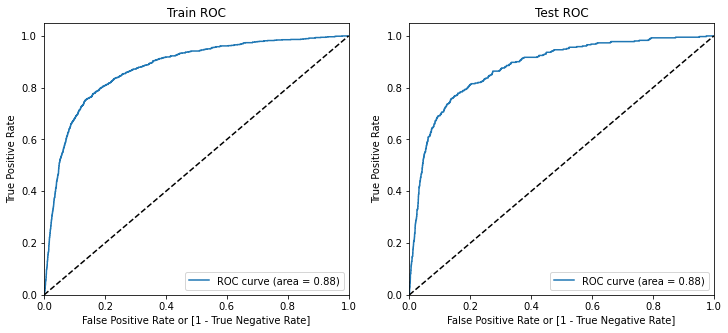

In [89]:
# Plot the ROC
draw_roc(y_train, log_final.predict_proba(X_train_rfe)[:,1], y_test, log_final.predict_proba(X_test_rfe)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [90]:
# Store the Sensitivity results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Logistic with RFE'], 'Sensitivity': round(sensi, 2), 
                              'Specificity': round(speci, 2), 'AUC': round(auc, 2)}, index = {'5'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87
3       AdaBoost with PCA         0.92         0.62  0.88
4                 XGBoost         0.91         0.62  0.88
5       Logistic with RFE         0.90         0.66  0.88

### Decision Tree

- Decision Tree is not affected by multicollinearity. So RFE is not required for Decision Tree
- Hence complete dataset is used i.e. with 118 features
- Now tune the hyperparameters of Decision Tree model

In [91]:
# Hyperparameter tuning of Decision Tree
dctree = DecisionTreeClassifier(random_state = 100, criterion = 'entropy')

# Select Hyperparameters -> class_weight to handle imbalance in data
weights = np.linspace(0.01, 0.02, 5)
classWeights = [{0:x, 1:1.0-x} for x in weights]

# Create the parameter grid 
dt_params = {'max_depth': [3, 5], 'min_samples_leaf': [50, 100], 'min_samples_split': [25, 50],
             'class_weight': classWeights}

# Defining multiple metric evaluation scoring. We are using a combination of recall and F1 Score
scoring = {'f1score': 'f1', 'recall': 'recall'}

# Create Gridsearch Cross Validation object
dt_model = GridSearchCV(estimator = dctree, cv = 3, param_grid = dt_params, n_jobs = -1, verbose = 1,
                       scoring = scoring, refit = 'f1score')

# Fit the Decision Tree model (on the complete dataset i.e. with 118 features)
dt_model.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   47.6s finished


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=100),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.0125, 1: 0.9875},
                                          {0: 0.015, 1: 0.985},
                                          {0: 0.0175, 1: 0.9825},
                                          {0: 0.02, 1: 0.98}],
                         'max_depth': [3, 5], 'min_samples_leaf': [50, 100],
                         'min_samples_split': [25, 50]},
             refit='f1score', scoring={'f1score': 'f1', 'recall': 'recall'},
             verbose=1)

In [92]:
# Get best hyperparameters
print('Best F1 Score:        ', dt_model.best_score_)
print('Best hyperparameters: ', dt_model.best_params_)

Best F1 Score:         0.2198547978745483
Best hyperparameters:  {'class_weight': {0: 0.02, 1: 0.98}, 'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 25}


#### Final Decision Tree model

In [93]:
# Final Decision Tree Model using the parameters determined above
dt_final = DecisionTreeClassifier(class_weight = {0: 0.02, 1: 0.98}, criterion = 'entropy', max_depth = 5, 
                                  min_samples_leaf = 50, min_samples_split = 25)

# Fit the Decision Tree model
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.02, 1: 0.98}, criterion='entropy',
                       max_depth=5, min_samples_leaf=50, min_samples_split=25)

#### Evaluate the model on the Train and Test Data

- Evaluating the final model on Train and Test data and comparing them to see if train and test performance are comparable.
- Using derive metrics sensitivity, specificity and AUC  at default cut off 0.5

In [94]:
# Train performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci','auc'])

y_pred_test = dt_final.predict(X_train)

cm = metrics.confusion_matrix(y_train, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_train, dt_final.predict_proba(X_train)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.947971  0.635561  0.909696


In [95]:
# Test performance

# Now let's calculate sensitivity, specificity and AUC
metrics_df = pd.DataFrame(columns = ['sensi','speci', 'auc'])

y_pred_test = dt_final.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_test)

# TP = confusion[1,1] # True Positive 
# TN = confusion[0,0] # True Negative
# FP = confusion[0,1] # False Positive
# FN = confusion[1,0] # False Negative
speci = cm[0,0]/(cm[0,0] + cm[0,1])
sensi = cm[1,1]/(cm[1,0] + cm[1,1])
auc = roc_auc_score(y_test, dt_final.predict_proba(X_test)[:,1])

# Update the dataframe
metrics_df.loc[0] = [sensi, speci, auc]

print(metrics_df)

      sensi     speci       auc
0  0.893204  0.644271  0.870725


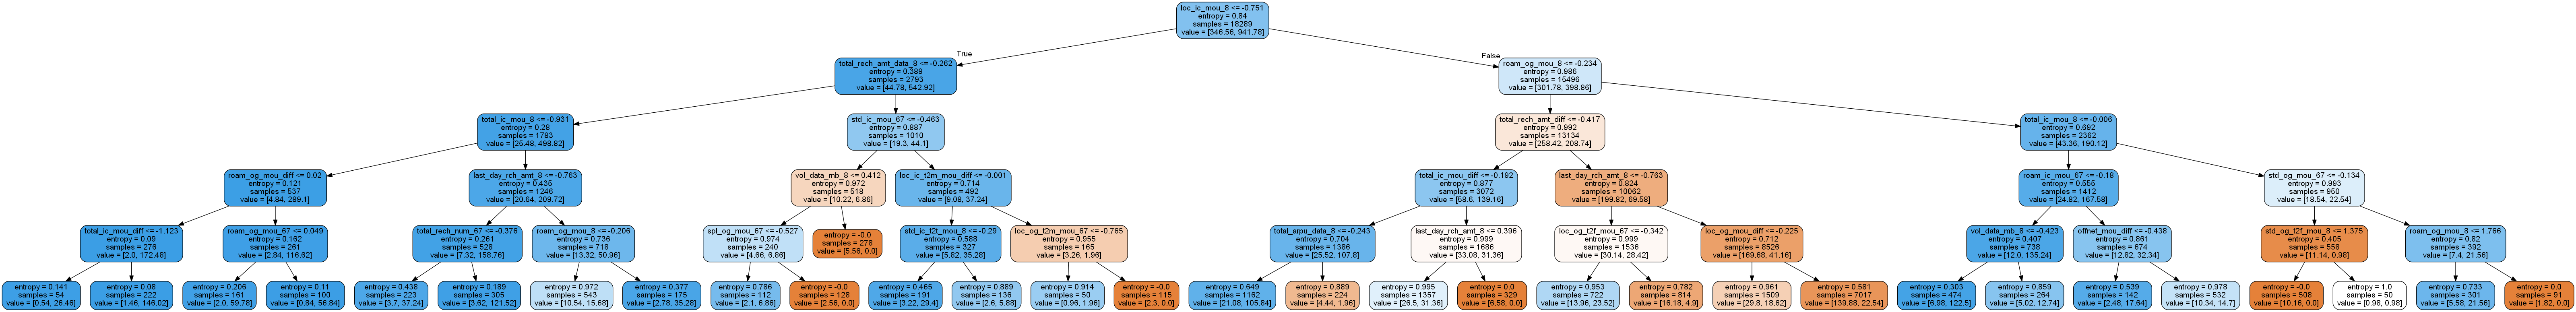

In [96]:
# Printing the final decision tree model
dot_data = StringIO()   

# Putting features
features = list(X_train.columns[0:])

export_graphviz(dt_final, out_file = dot_data, feature_names = features, filled = True, rounded = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

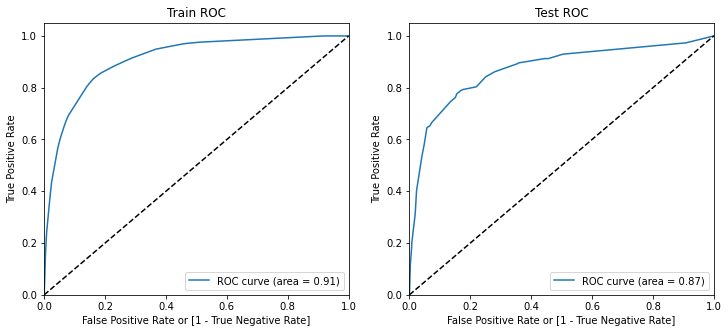

In [97]:
# Plot the ROC
draw_roc(y_train, dt_final.predict_proba(X_train)[:,1], y_test, dt_final.predict_proba(X_test)[:,1])

Training and Testing performance are very close so our model is not overfitting

In [98]:
# Store the Sensitivity results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Sensitivity': round(sensi, 2), 
                              'Specificity': round(speci, 2), 'AUC': round(auc, 2)}, index = {'6'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'Sensitivity', 'Specificity', 'AUC']]
results

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87
3       AdaBoost with PCA         0.92         0.62  0.88
4                 XGBoost         0.91         0.62  0.88
5       Logistic with RFE         0.90         0.66  0.88
6           Decision Tree         0.89         0.64  0.87

## Step 5: Final Model Selection

- Select the best model for prediction based on the models derived after PCA
- Select the best model to explain the predictors

### Best model for Prediction

In [99]:
# Best model for prediction

# First five rows of the results dataframe show the results of the models created after PCA
results[0:4]

Method  Sensitivity  Specificity   AUC
1       Logistic with PCA         0.92         0.53  0.87
2  Random Forest with PCA         0.90         0.62  0.87
3       AdaBoost with PCA         0.92         0.62  0.88
4                 XGBoost         0.91         0.62  0.88

- From the table above, it is clear that the AdaBoost Model has slightly performed better than Logistic, RF and XGBoost Models
- __AdaBoost built on 41 PCs of PCA__ has the best Sensitivity (i.e. the ability to correctly predict Churn)

In [100]:
# Final Model selected
# AdaBoost Model built on 41 PCs of PCA
print(adab_pca_final)
print('\nGini Importance of 41 PCs of PCA:')
list(zip(['PC'+str(x) for x in range(1,42)], round(pd.Series(adab_pca_final.feature_importances_),4)))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.02,
                                                                       1: 0.98},
                                                         max_depth=2,
                                                         min_samples_leaf=200,
                                                         random_state=100),
                   learning_rate=0.2)

Gini Importance of 41 PCs of PCA:


[('PC1', 0.1381),
 ('PC2', 0.121),
 ('PC3', 0.0527),
 ('PC4', 0.0609),
 ('PC5', 0.0508),
 ('PC6', 0.055),
 ('PC7', 0.0501),
 ('PC8', 0.0485),
 ('PC9', 0.0049),
 ('PC10', 0.0067),
 ('PC11', 0.0424),
 ('PC12', 0.0257),
 ('PC13', 0.0061),
 ('PC14', 0.0237),
 ('PC15', 0.0188),
 ('PC16', 0.0184),
 ('PC17', 0.0),
 ('PC18', 0.0107),
 ('PC19', 0.0),
 ('PC20', 0.0),
 ('PC21', 0.0529),
 ('PC22', 0.0193),
 ('PC23', 0.0435),
 ('PC24', 0.0),
 ('PC25', 0.0145),
 ('PC26', 0.0184),
 ('PC27', 0.0),
 ('PC28', 0.0096),
 ('PC29', 0.017),
 ('PC30', 0.0166),
 ('PC31', 0.0),
 ('PC32', 0.0133),
 ('PC33', 0.0084),
 ('PC34', 0.0),
 ('PC35', 0.0),
 ('PC36', 0.021),
 ('PC37', 0.0085),
 ('PC38', 0.0),
 ('PC39', 0.0),
 ('PC40', 0.0148),
 ('PC41', 0.0076)]

### Best Model to Explain Important Predictors

In [101]:
# Best model to explain Predictors

# Last two rows of the results dataframe show the results of the models created to explain predictors
results[4:]

Method  Sensitivity  Specificity   AUC
5  Logistic with RFE         0.90         0.66  0.88
6      Decision Tree         0.89         0.64  0.87

- From the table above, it is clear the Logistic Regression has performed better than Decision Tree
- __Logistic Regression Model__ has the best Sensitivity (i.e. the ability to correctly predict Churn)

## Conclusion

In [102]:
# Final Model selected
# Logistic Regression Model built on 40 features of dataframe
print(log_final)

print('\nFeatures and coefficients:')
# Printing the absolute values of columns coefficients to get better idea
# Sorting the df by absolute coefficient value
log_df = pd.DataFrame(list(zip(X_train_rfe.columns, log_final.coef_.reshape(40,))), columns = ['Column', 'Coefficient']) 
log_df['abs_coeff'] = log_df.Coefficient.abs()
log_df.sort_values(by = 'abs_coeff', ascending = False)

LogisticRegression(C=0.5, class_weight={0: 0.03, 1: 0.97}, penalty='l1',
                   solver='saga')

Features and coefficients:


Column  Coefficient  abs_coeff
35         monthly_data_8    -0.531789   0.531789
21           spl_ic_mou_8    -0.514857   0.514857
37          sachet_data_8    -0.387835   0.387835
19      total_ic_mou_diff    -0.384501   0.384501
26    total_rech_amt_diff    -0.381239   0.381239
16           loc_ic_mou_8    -0.348936   0.348936
6        loc_og_t2m_mou_8    -0.332806   0.332806
4           roam_og_mou_8     0.289227   0.289227
29     last_day_rch_amt_8    -0.283111   0.283111
32          vol_data_mb_8    -0.275907   0.275907
5       loc_og_t2m_mou_67    -0.263163   0.263163
39                    aon    -0.237935   0.237935
27         max_rech_amt_8     0.233323   0.233323
17           std_ic_mou_8    -0.226809   0.226809
30  total_rech_amt_data_8     0.204447   0.204447
0                 arpu_67     0.183635   0.183635
23       total_rech_num_8    -0.160671   0.160671
33       vol_data_mb_diff    -0.133738   0.133738
14       loc_ic_t2f_mou_8    -0.132572   0.132572
38       sachet_data_diff    -0.129268   0.129268
12       loc_ic_t2m_mou_8    -0.123488   0.123488
10       loc_ic_t2t_mou_8    -0.106221   0.106221
28    last_day_rch_amt_67    -0.069216   0.069216
3         offnet_mou_diff    -0.068290   0.068290
2           offnet_mou_67     0.052135   0.052135
13    loc_ic_t2m_mou_diff    -0.028996   0.028996
22        spl_ic_mou_diff    -0.018095   0.018095
18         total_ic_mou_8    -0.004446   0.004446
7     loc_og_t2m_mou_diff     0.000000   0.000000
36         sachet_data_67     0.000000   0.000000
34        monthly_data_67     0.000000   0.000000
15          loc_ic_mou_67     0.000000   0.000000
31         vol_data_mb_67     0.000000   0.000000
8       std_og_t2m_mou_67     0.000000   0.000000
9     std_og_t2m_mou_diff     0.000000   0.000000
11      loc_ic_t2m_mou_67     0.000000   0.000000
25       total_rech_amt_8     0.000000   0.000000
24      total_rech_amt_67     0.000000   0.000000
1                  arpu_8     0.000000   0.000000
20          spl_ic_mou_67     0.000000   0.000000

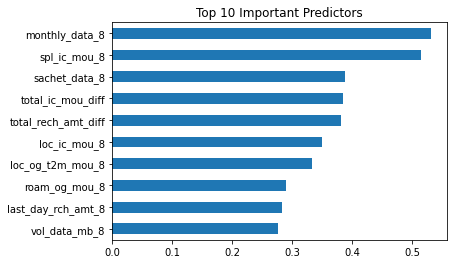

In [103]:
# Top 10 important features of the logistic regression model
imp_predictors = pd.Series(abs(log_final.coef_[0]), index = X_train_rfe.columns)
imp_predictors.sort_values()[-10:].plot(kind = 'barh', title = 'Top 10 Important Predictors')

### Recommendations

1. Monthly data usage in the month of August (monthly_data_8) is the topmost (negative) predictor of Churn
> This indicates that customers who have reduced their data usage in August are more likely to Churn and the same applies to: -
     - Special incoming minutes in August (spl_ic_mou_8)
     - Sachet data in August (sachet_data_8)
     - Local incoming minutes of usage in August (loc_ic_mou_8)
     - Local outgoing calls to other mobile networks in August (loc_og_t2m_mou_8)
     - Last day recharge amount in August (last_day_rch_amt_8)
     - Mobile internet usage volume (in MB) in August (vol_data_mb_8)
2. If the difference between the total incoming minutes of a customer in Action phase and Good phase (total_ic_mou_diff) is low, then the customer is likely to churn and the same applies to difference between the total recharge amount of a customer in Action phase and Good phase (total_rech_amt_diff)
3. Outgoing Minutes of usage while roaming in August (roam_og_mou_8) has a positive coefficient.
> This indicates that as the Outgoing Minutes of usage while roaming in August increases, the customer is likely to Churn as the person might have moved to another location and will probably buy a new number.
4. Broadly, the company should look at the usage of services by customers in August the most because that's what is affecting churn the most.